# Chapter 3 ndimage

In [1]:
import networkx as nx
import numpy as np

from scipy import ndimage as ndi

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint, mode='nearest', extra_arguments=(g,))
    return g

## 3.1 Image is just numpy array

In [2]:
# Apply customized style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

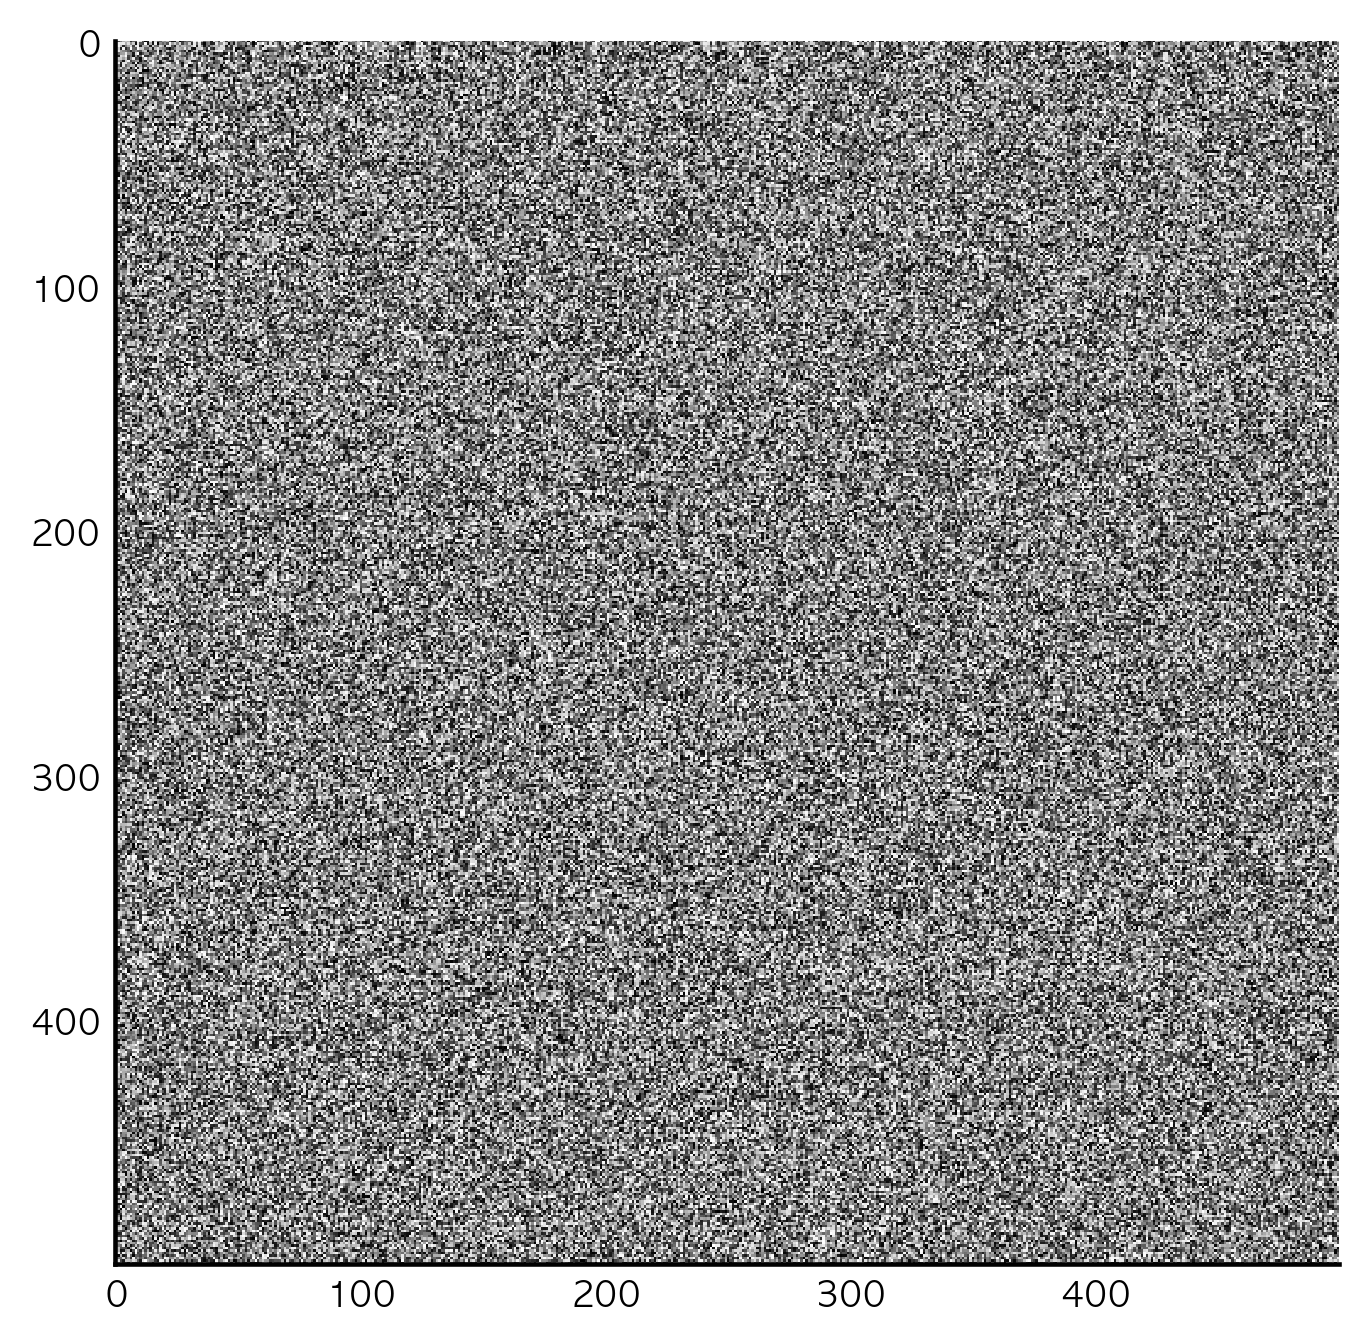

In [3]:
import numpy as np
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

Type: <class 'numpy.ndarray'> Shape: (303, 384) Data type: uint8


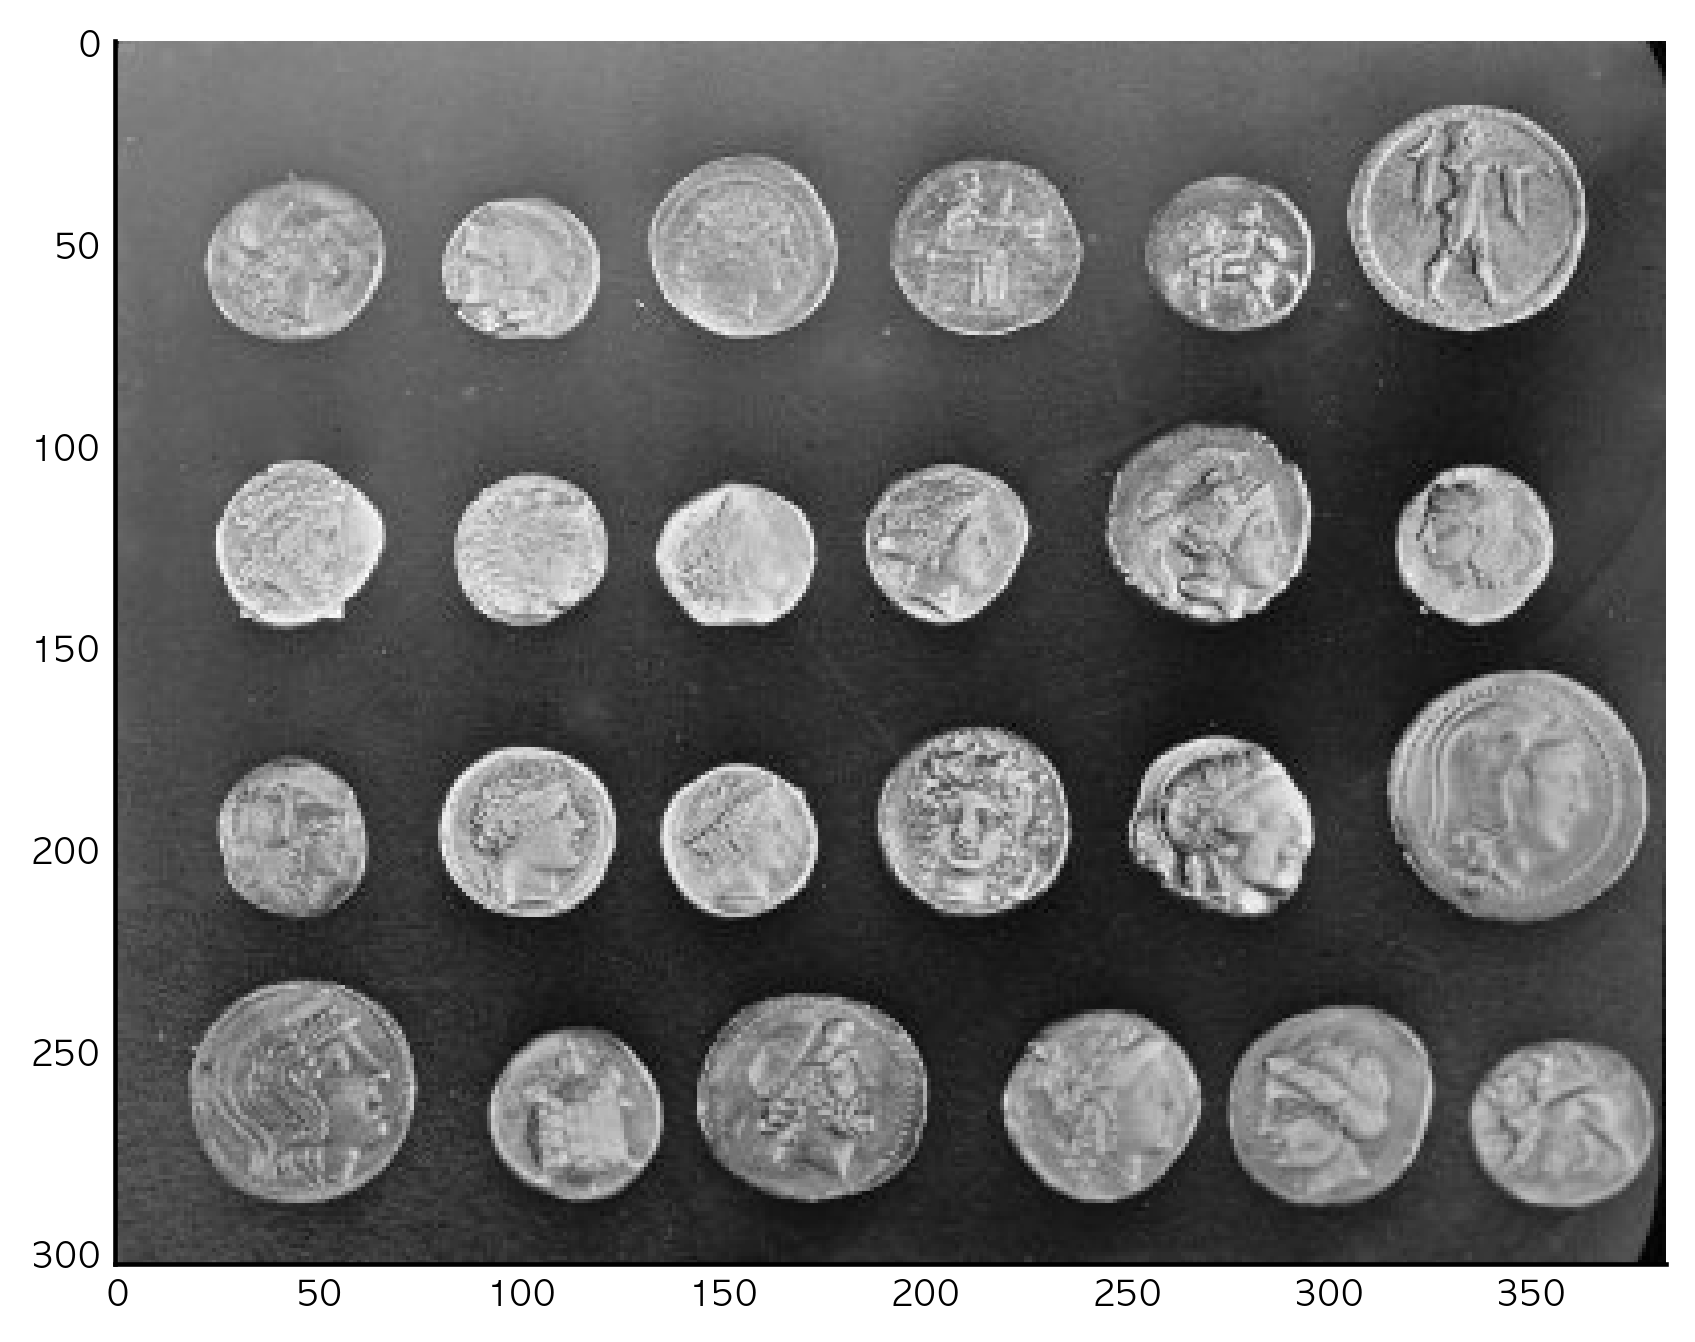

In [4]:
from skimage import io

url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                   'v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
print("Type:", type(coins), "Shape:", coins.shape, "Data type:", coins.dtype)
plt.imshow(coins);

Type: <class 'numpy.ndarray'> Shape: (512, 512, 3) Data type: uint8


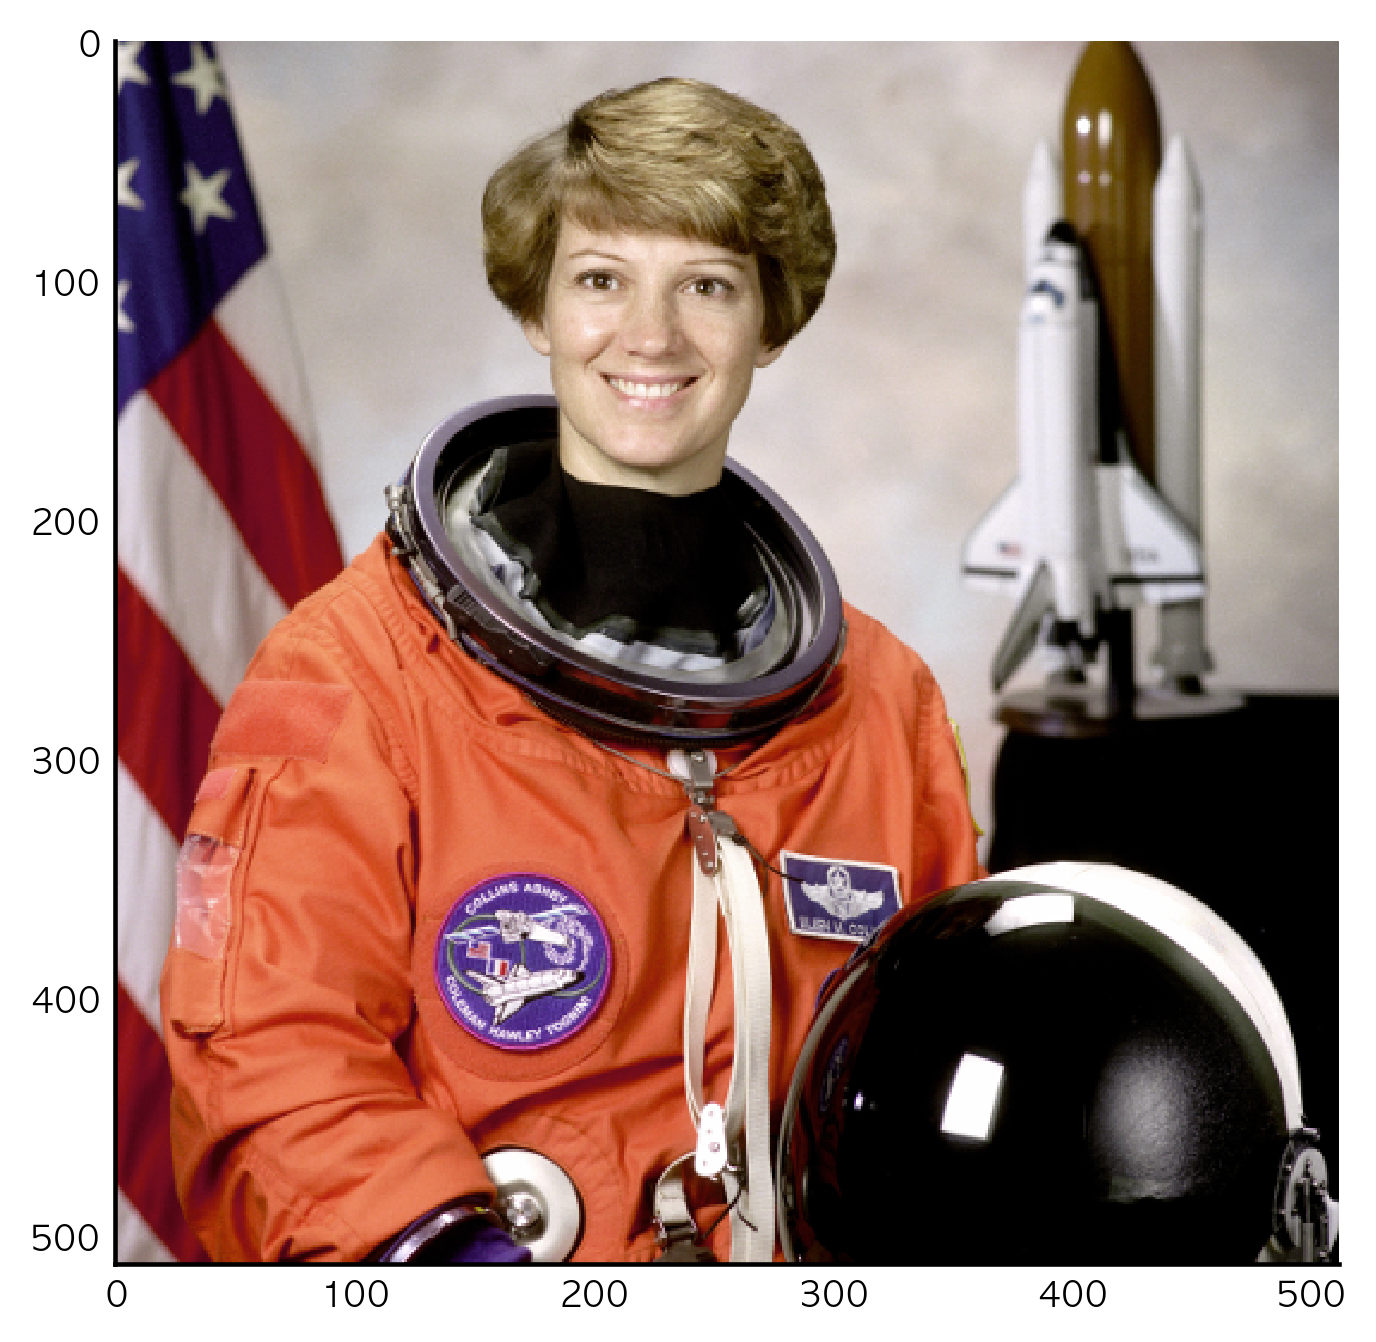

In [5]:
url_astronaut = ('https://raw.githubusercontent.com/scikit-image/scikit-image/'
                    'master/skimage/data/astronaut.png')
astro = io.imread(url_astronaut)
print("Type:", type(astro), "Shape:", astro.shape, "Data type:", astro.dtype)
plt.imshow(astro);

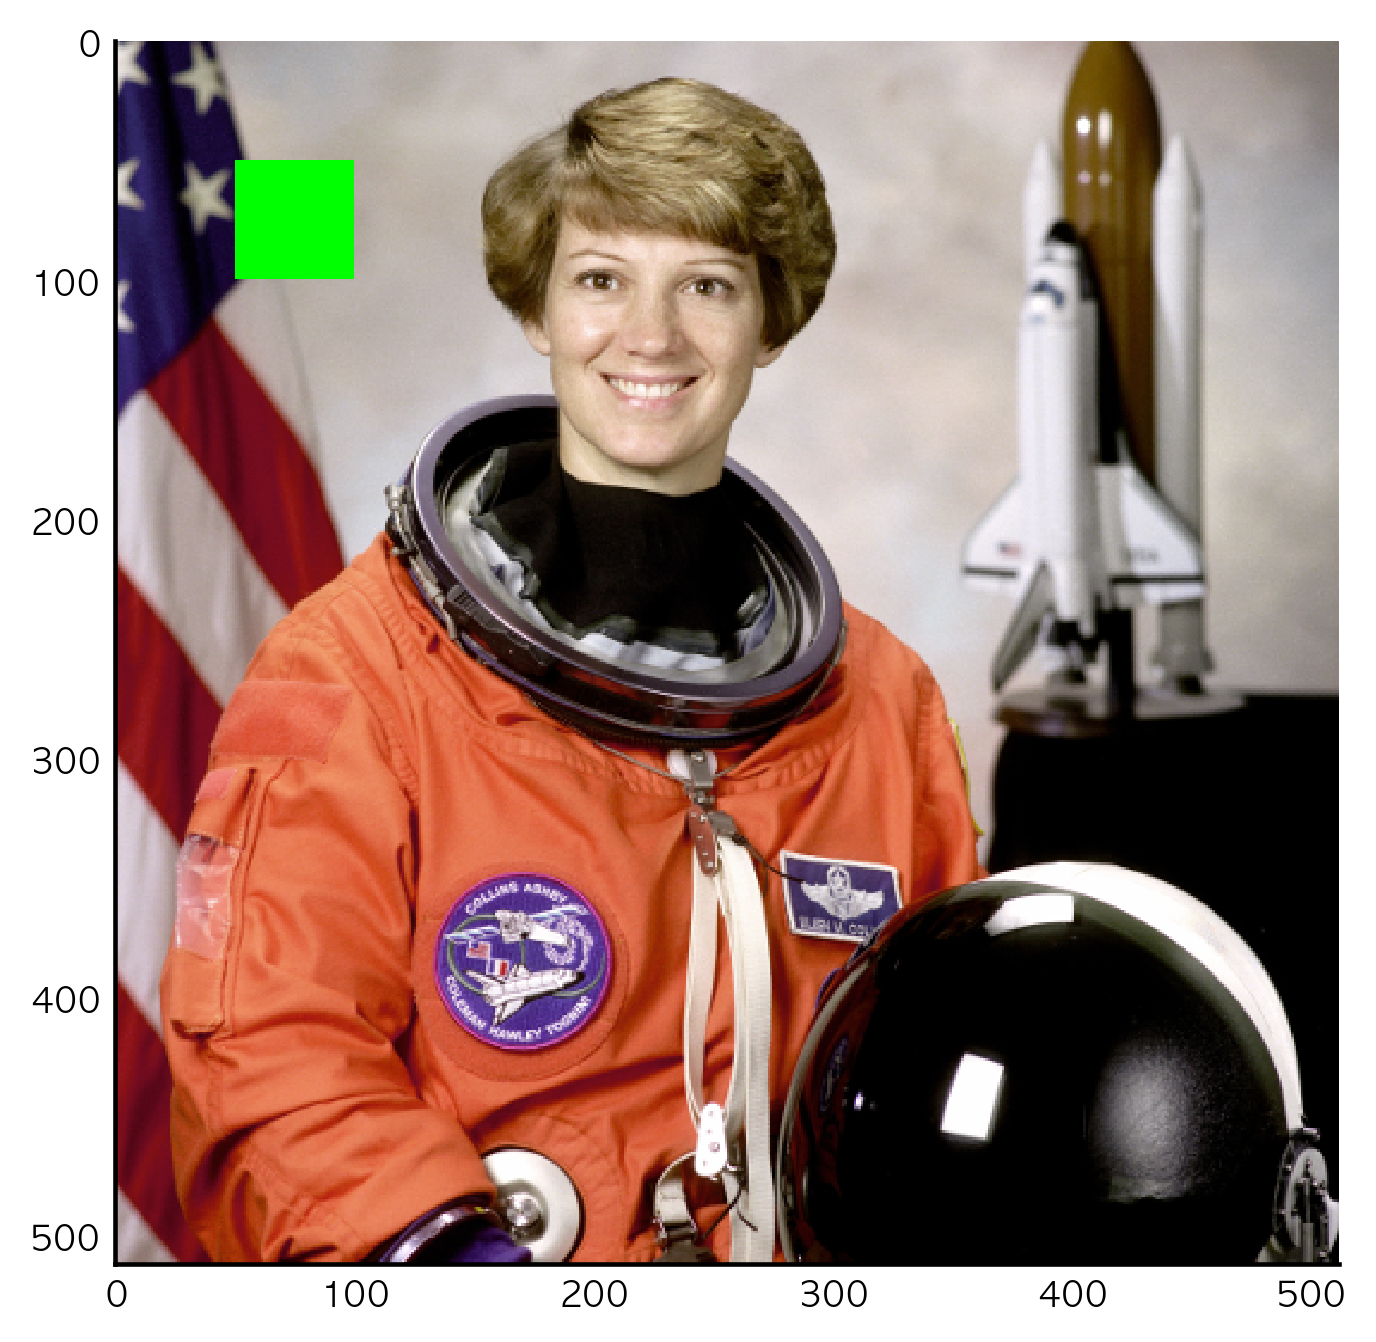

In [6]:
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 255, 0]
plt.imshow(astro_sq);

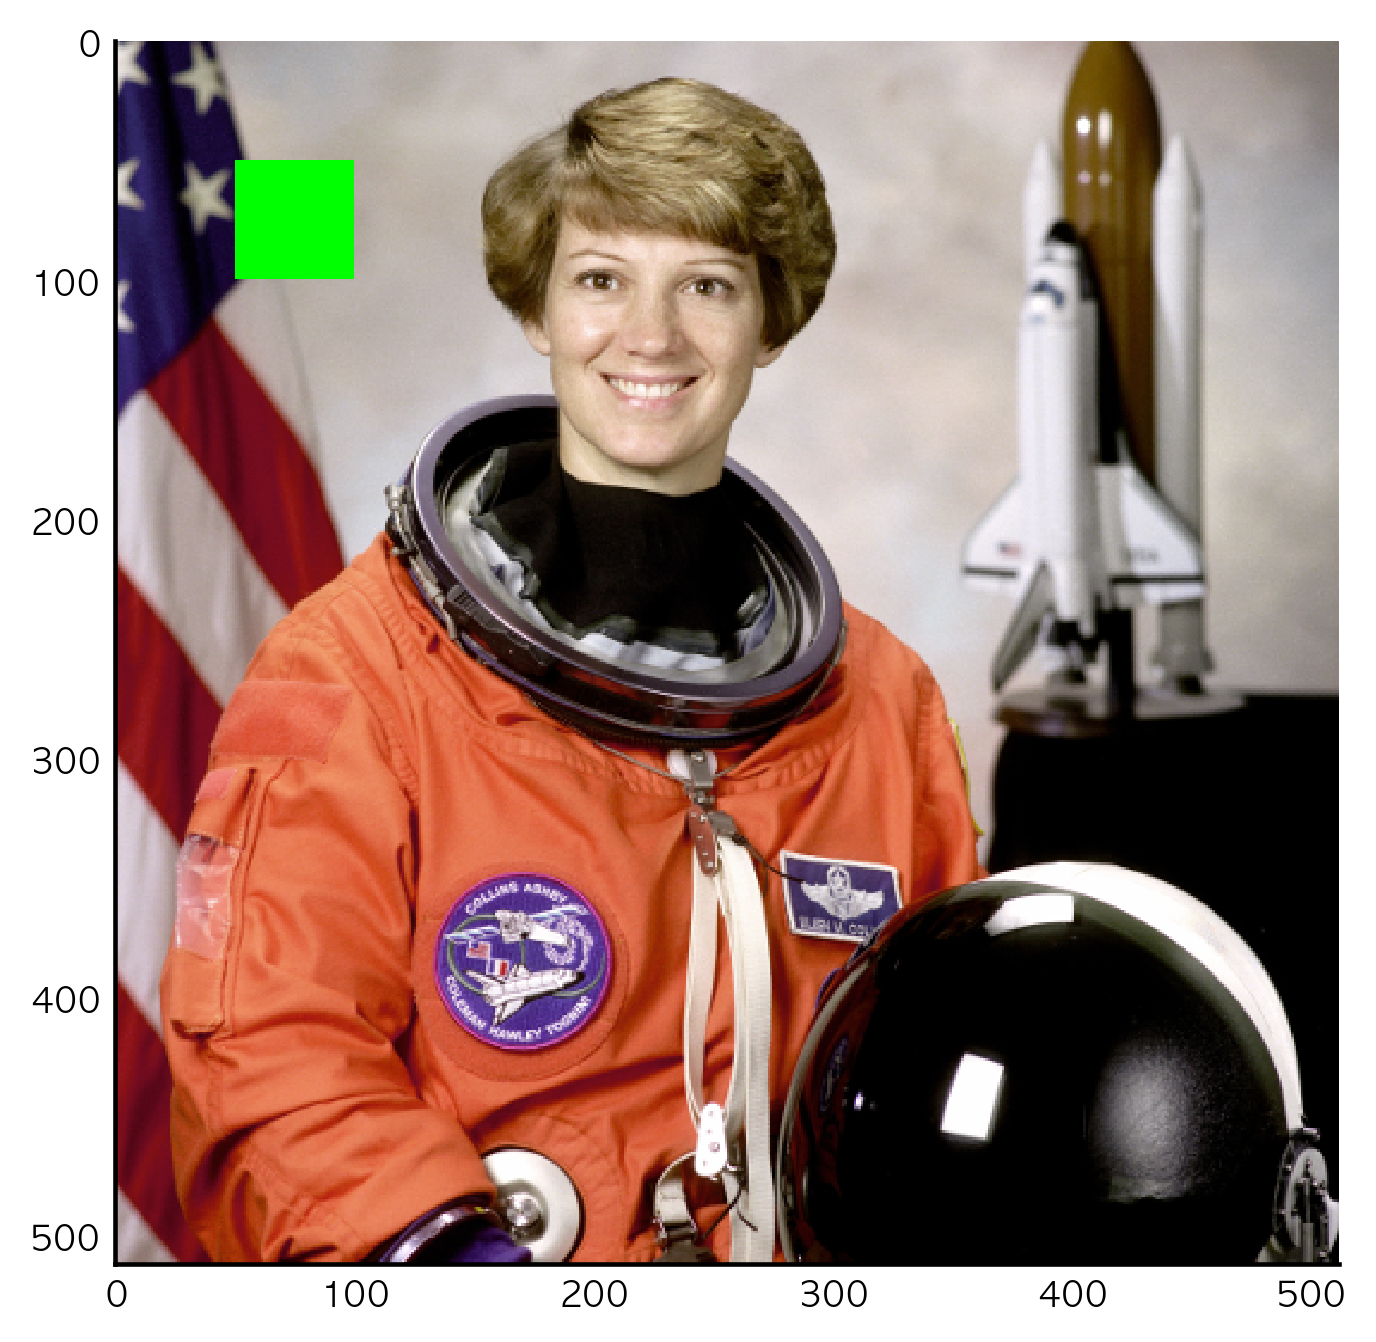

In [7]:
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[50:100, 50:100] = True
astro_sq[sq_mask] = [0, 255, 0]
plt.imshow(astro_sq);

## 3.2 Signal Disposal Filter

/var/folders/vb/krys120j39vc59j81xmj9d8r0000gn/T/ipykernel_11328/11998339.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sig = np.zeros(100, np.float)


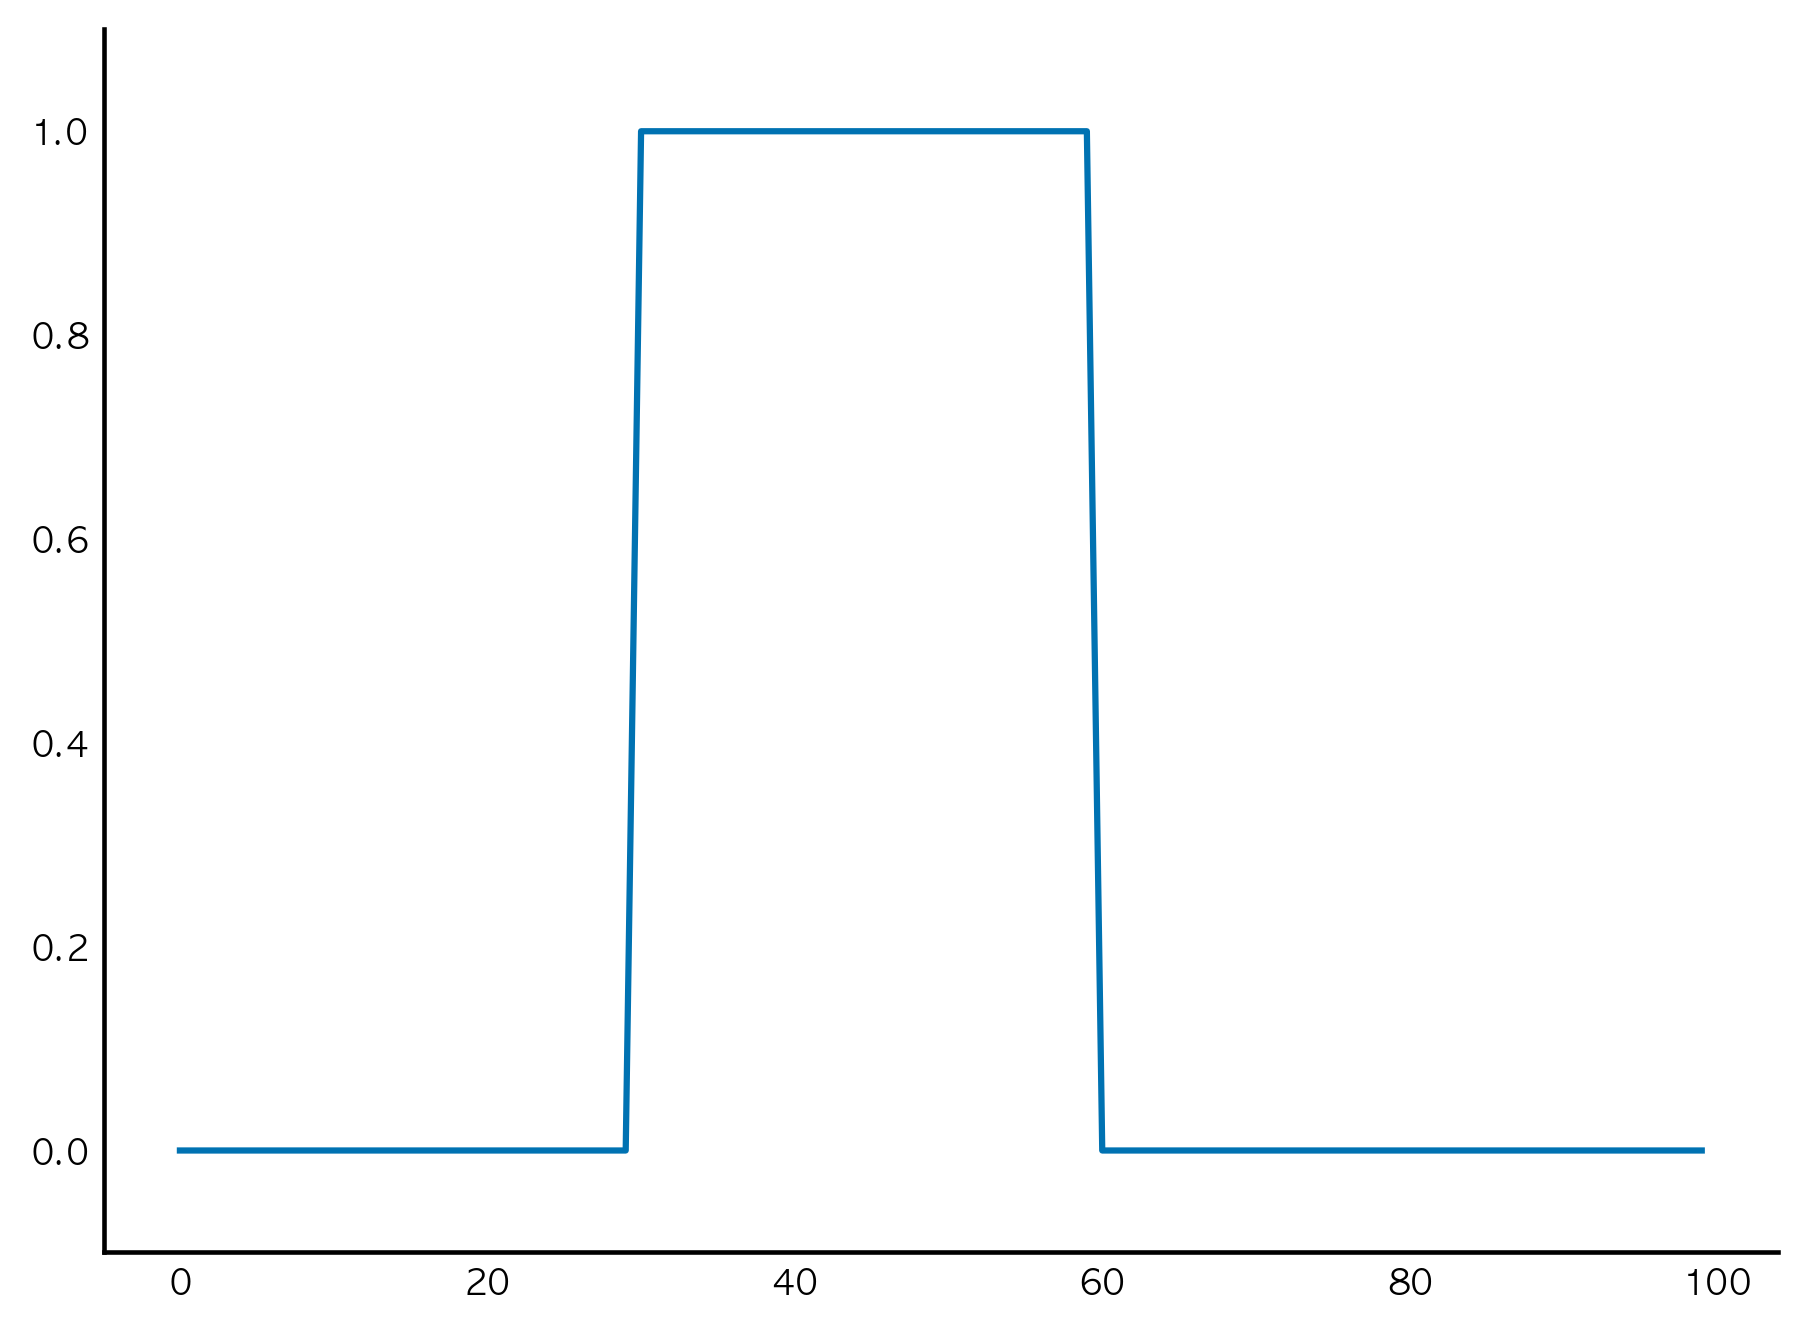

In [8]:
sig = np.zeros(100, np.float)
sig[30:60] = 1 # signal = 1 # light collected during 30-60ms
fig, ax = plt.subplots()
ax.plot(sig);
ax.set_ylim(-0.1, 1.1);

Signal duration time: 30 ms


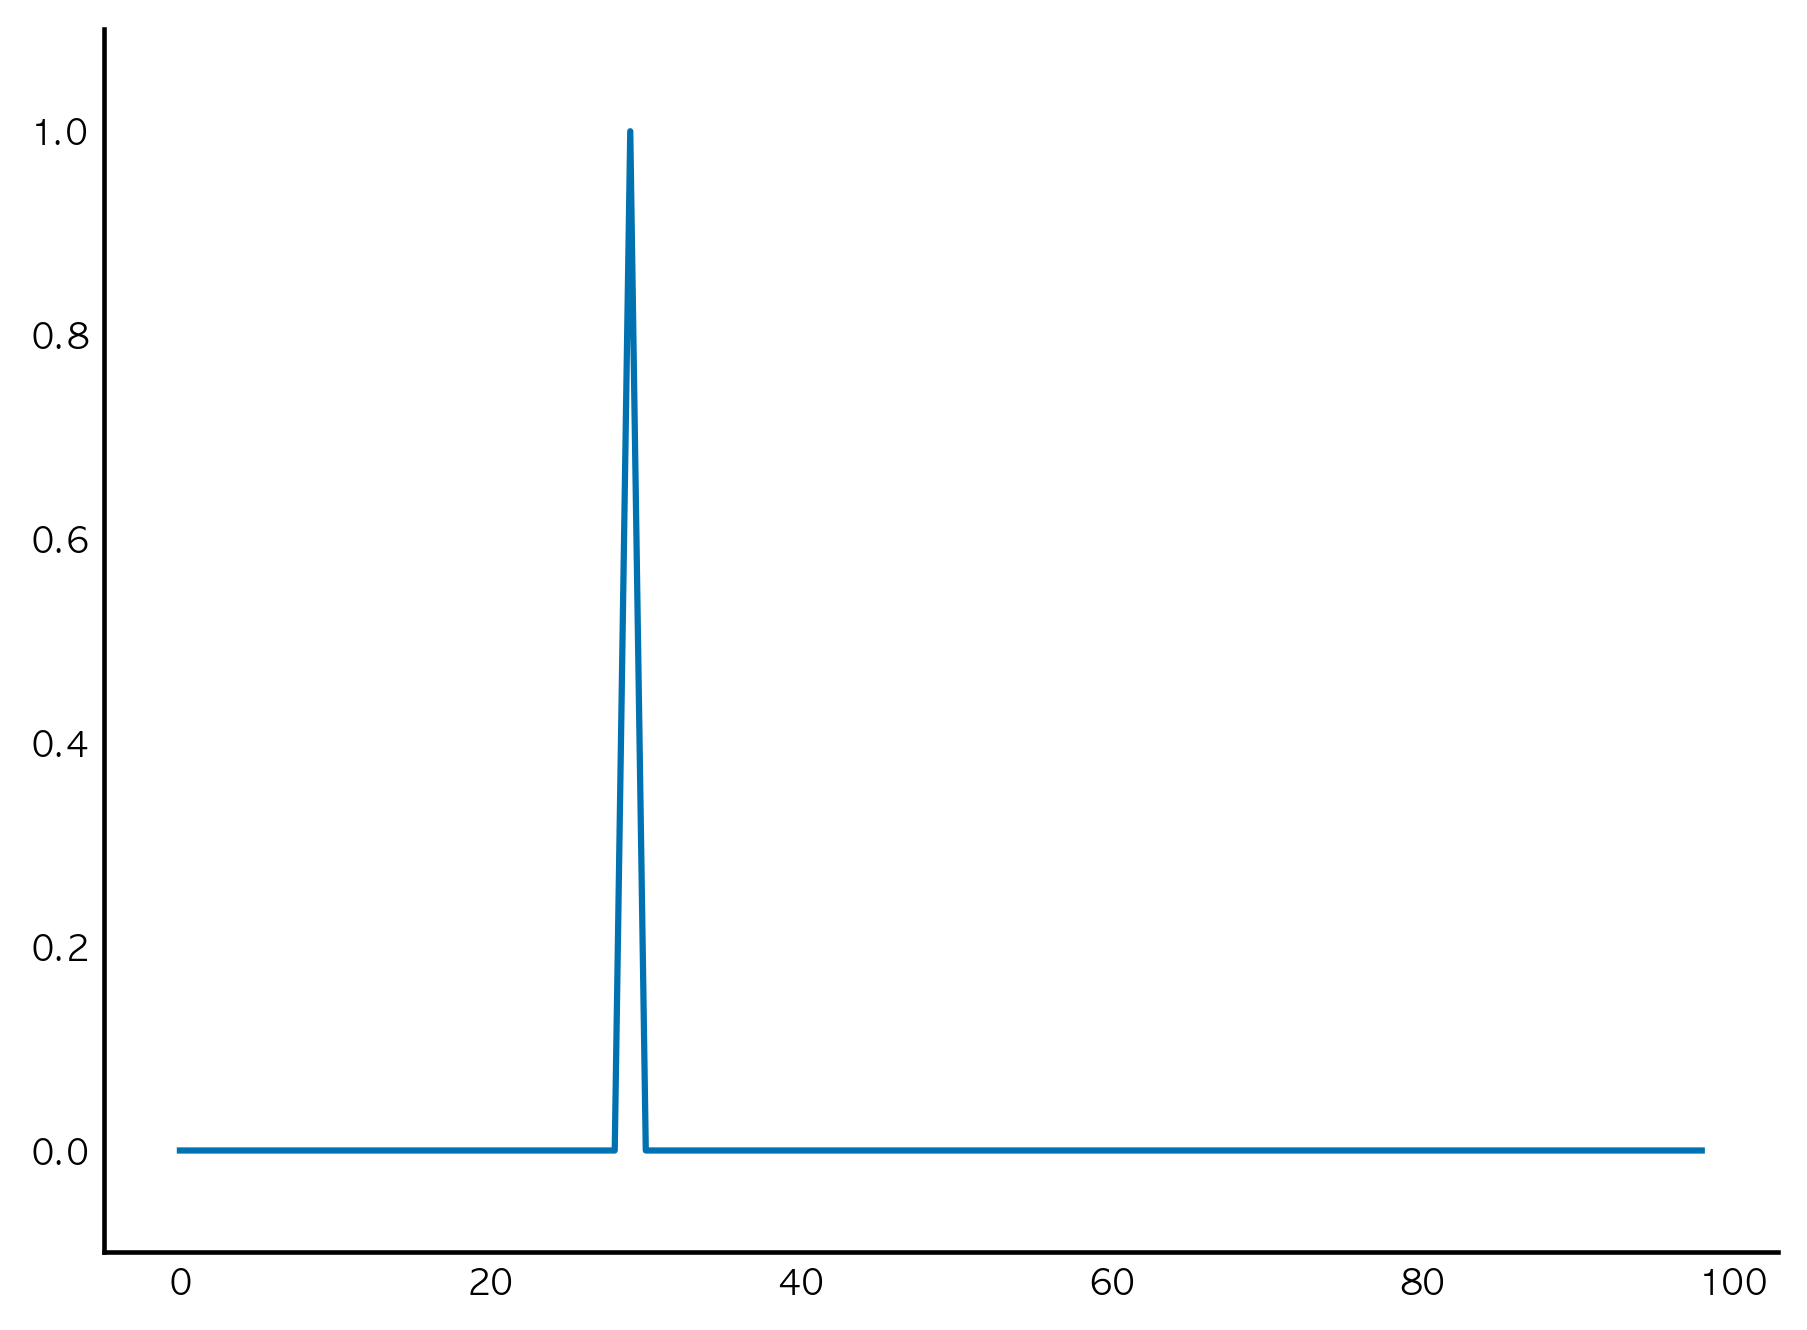

In [9]:
sigdelta = sig[1:] # sigdelta[0], sigdelta[1]... is equal to sig[1], sig[2], ..., respectively
sigdiff = sigdelta - sig[:-1]
sigon = np.clip(sigdiff, 0, np.inf)
fig, ax = plt.subplots()
ax.plot(sigon)
ax.set_ylim(-0.1, 1.1)
print('Signal duration time:', 1 + np.flatnonzero(sigon)[0], 'ms')

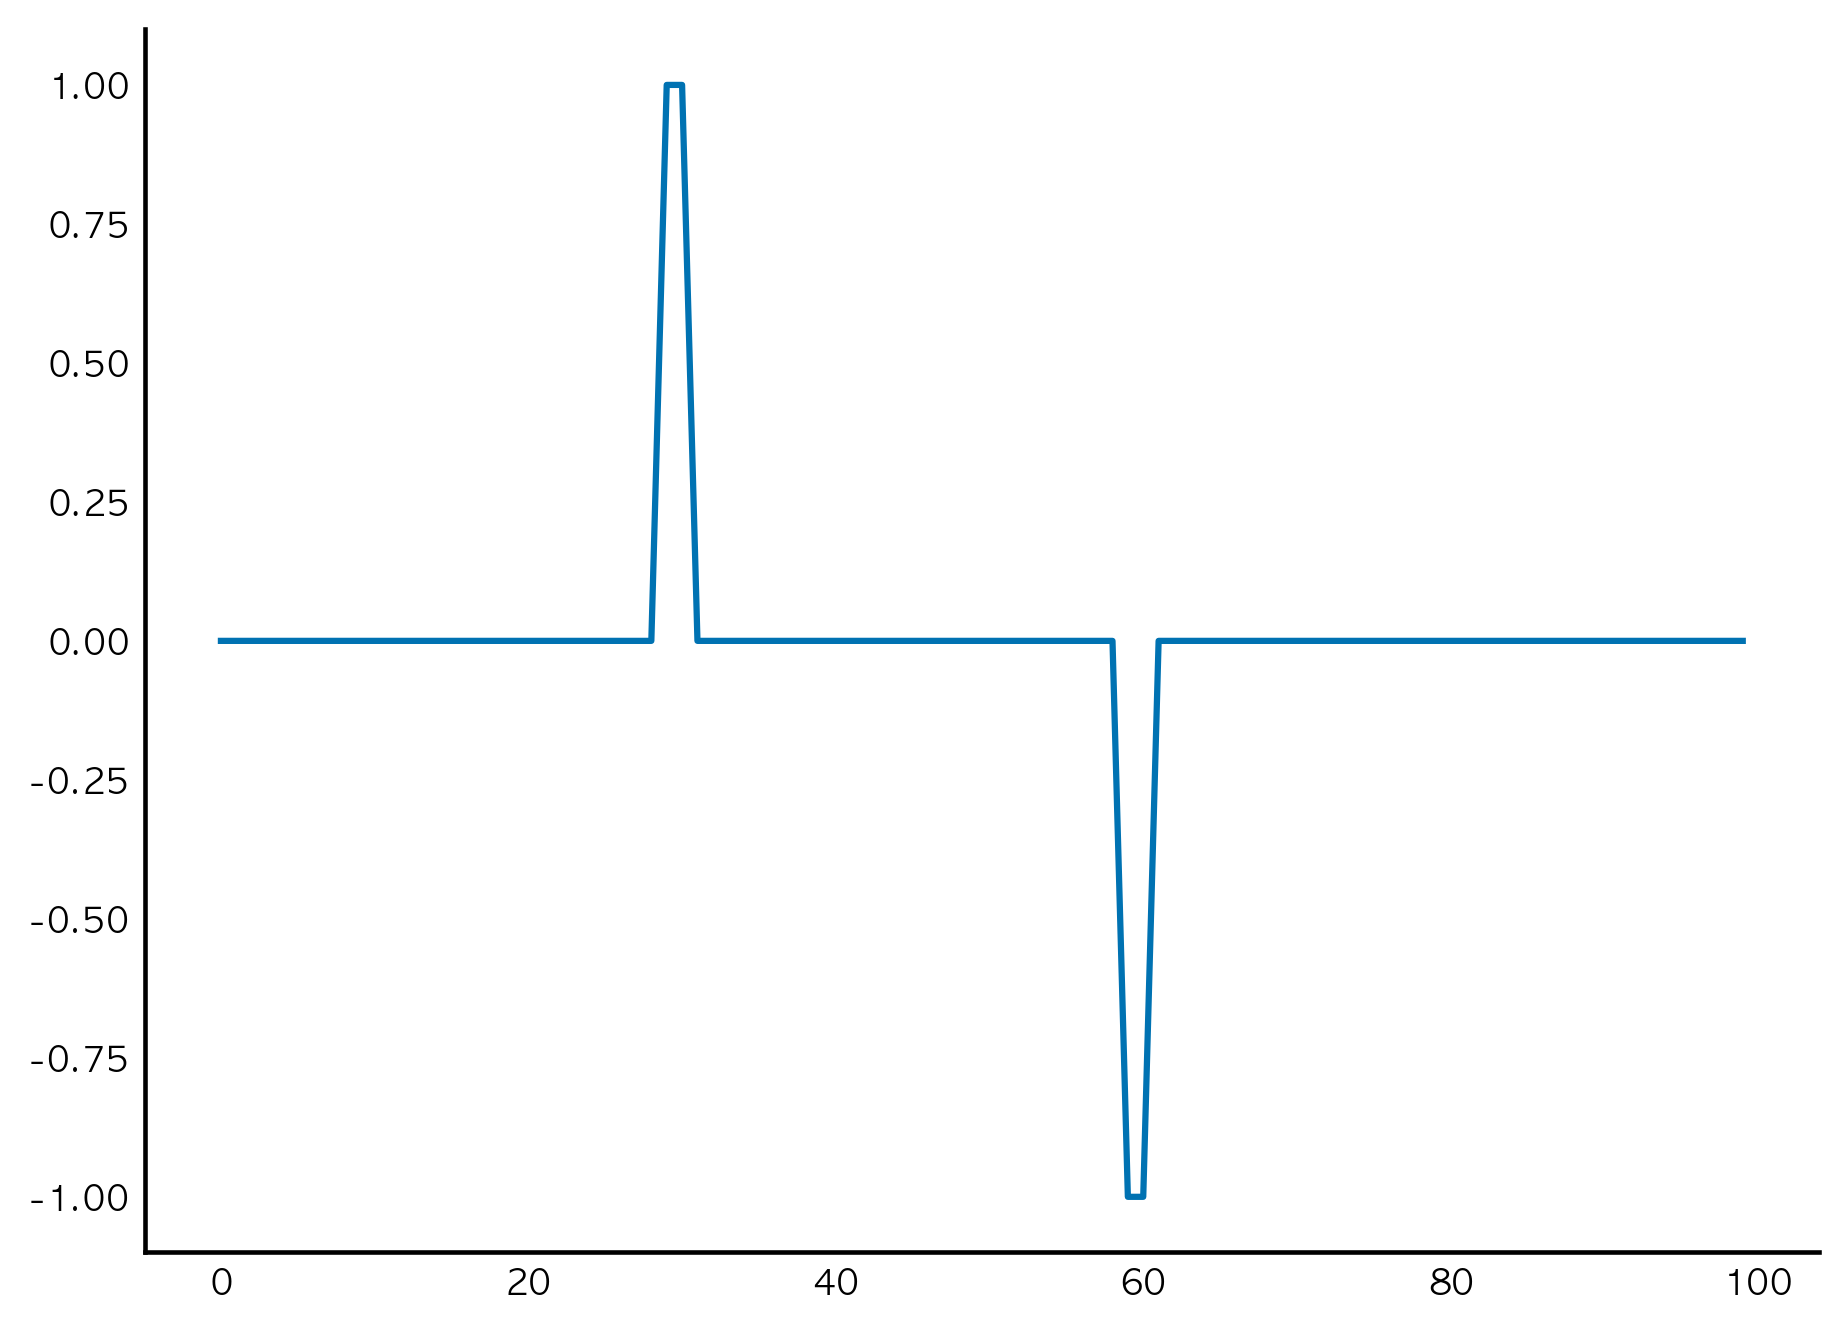

In [10]:
from scipy import ndimage as ndi
diff = np.array([1, 0, -1])
dsig = ndi.convolve(sig, diff)
plt.plot(dsig);

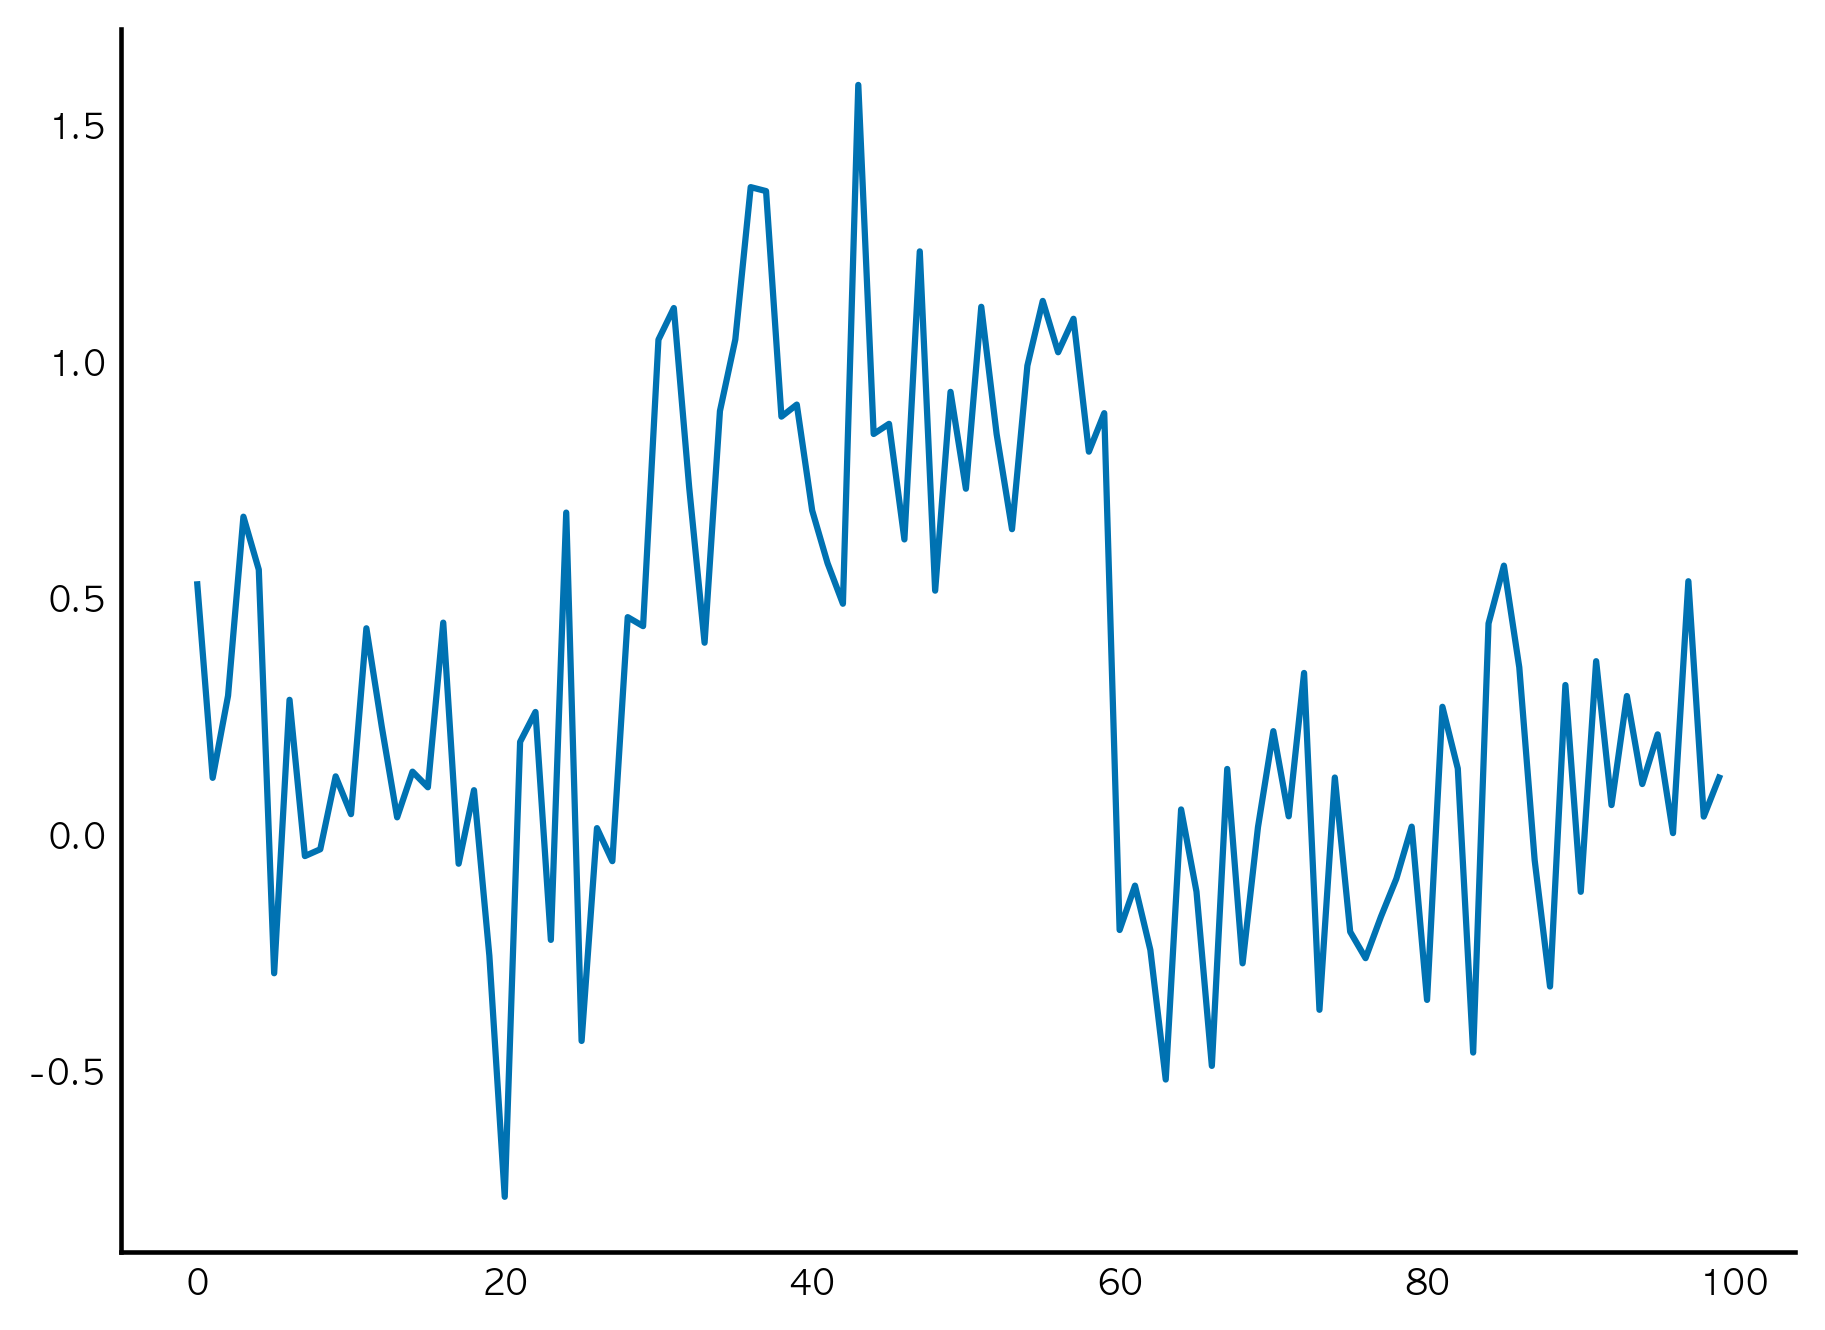

In [11]:
np.random.seed(0)
sig = sig + np.random.normal(0, 0.3, size=sig.shape)
plt.plot(sig);

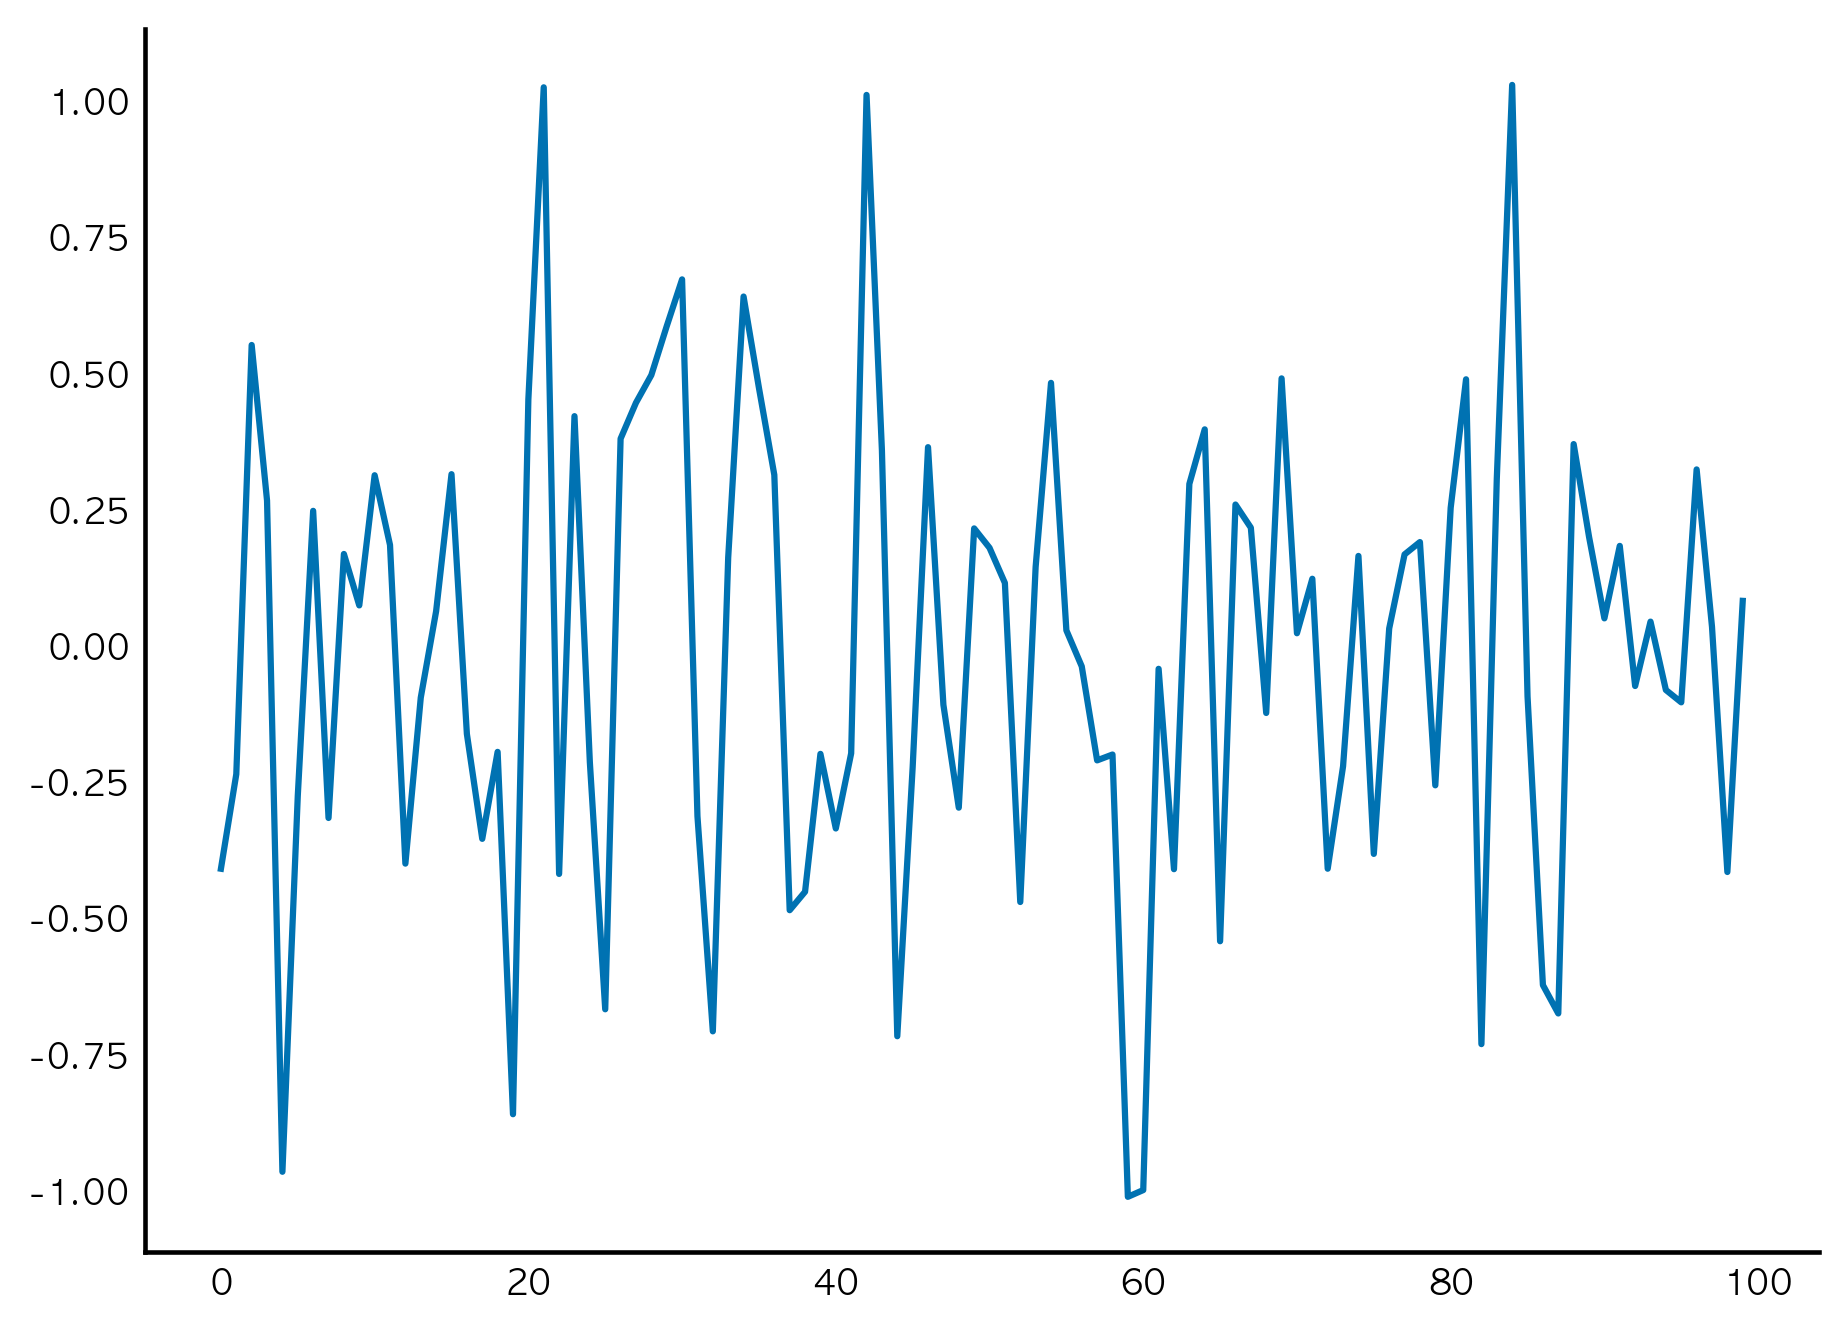

In [12]:
plt.plot(ndi.convolve(sig, diff));

In [17]:
def gaussian_kernel(size, sigma):
    """ Return 1 dimensional gauss kernal of designated size and standard deviation
    
    for enough range, size need to be odd number and
    at least larger 6 times more than sigma
    """
    positions = np.arange(size) - size // 2
    kernel_raw = np.exp(-positions**2 / (2 * sigma**2))
    kernel_normalized = kernel_raw / np.sum(kernel_raw)
    return kernel_normalized

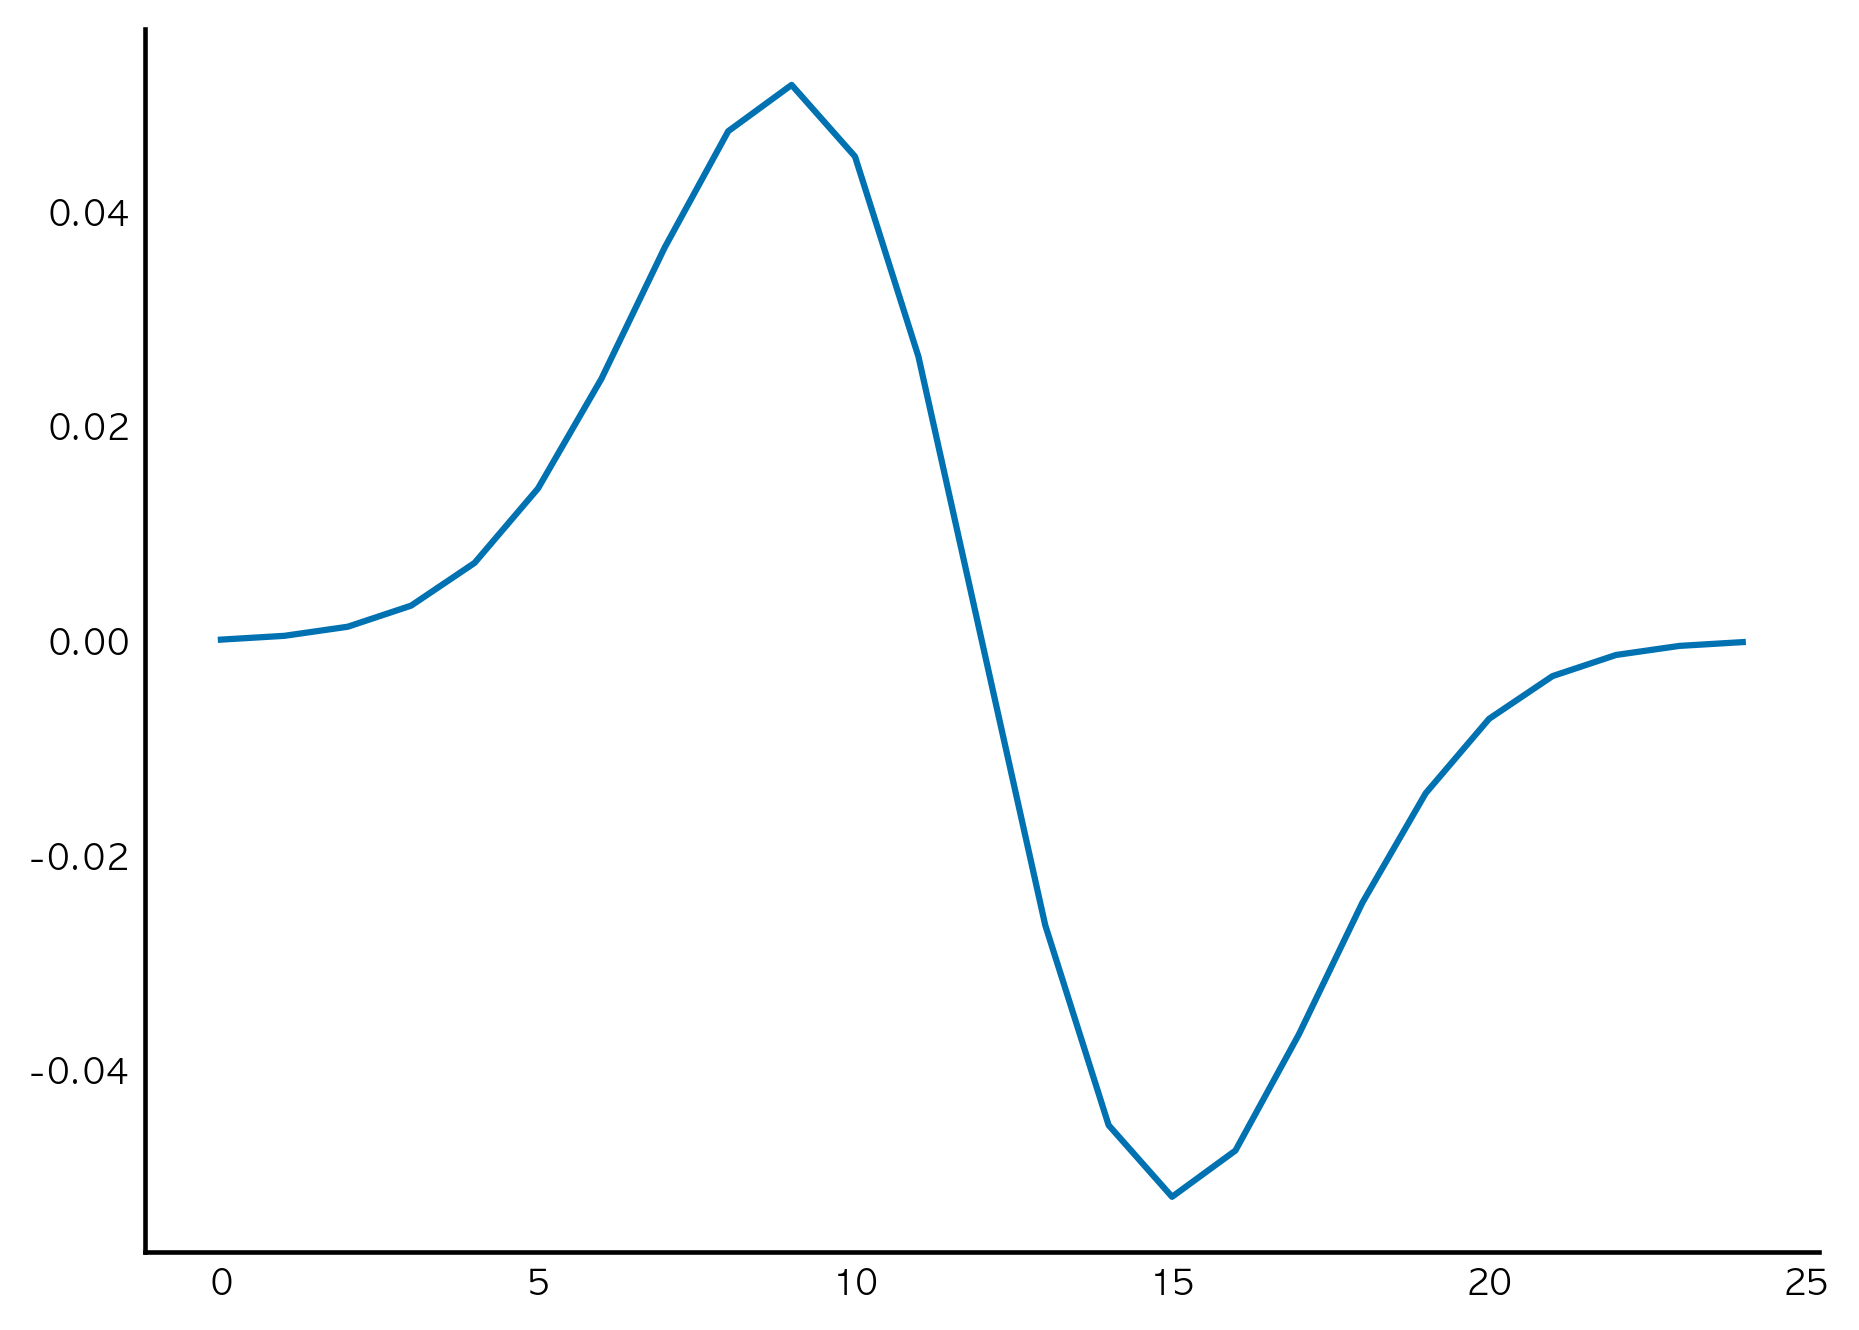

In [18]:
smooth_diff = ndi.convolve(gaussian_kernel(25, 3), diff)
plt.plot(smooth_diff);

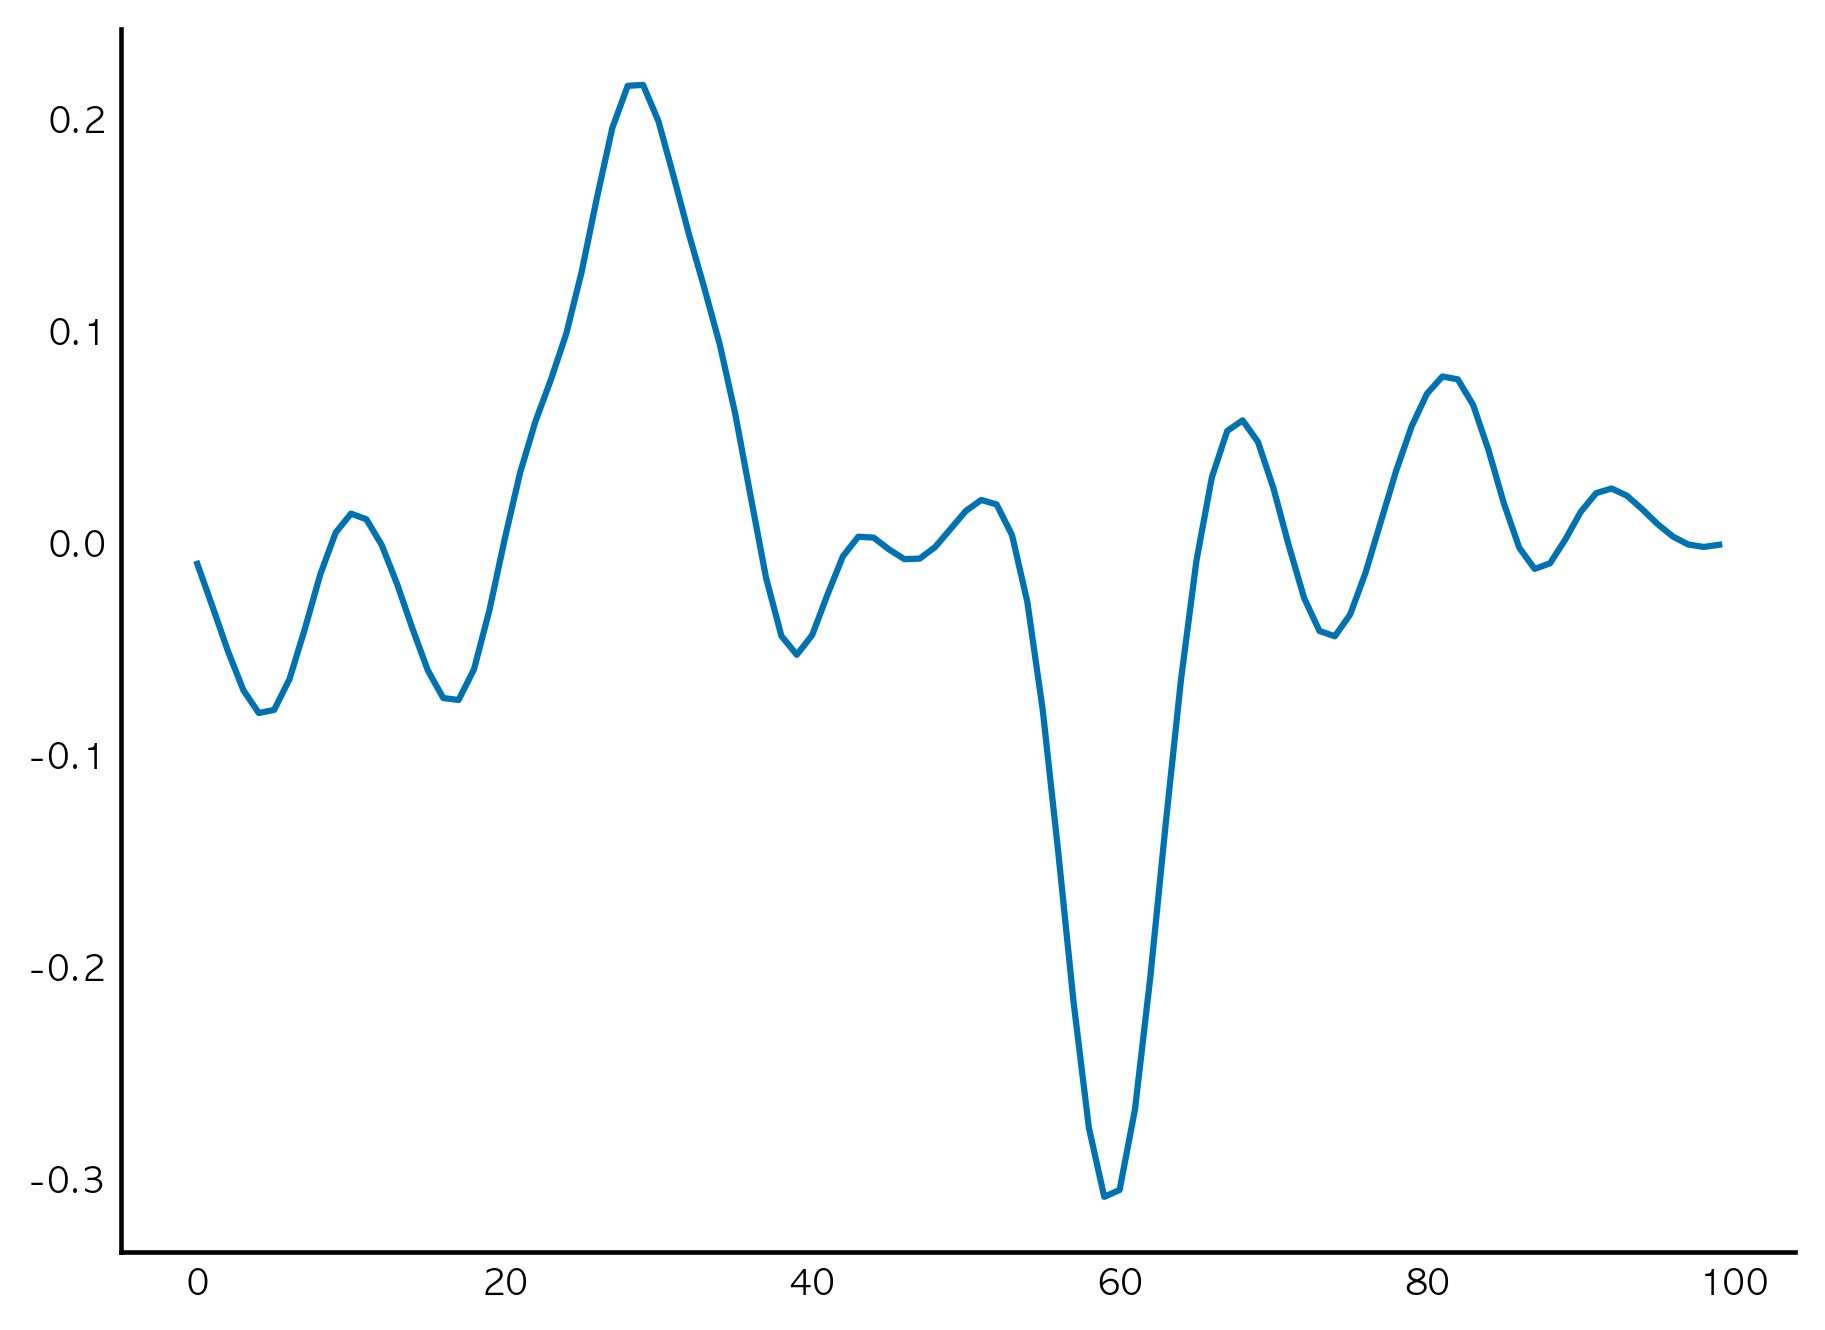

In [19]:
sdsig = ndi.convolve(sig, smooth_diff)
plt.plot(sdsig);

## 3.3 Image Filtering

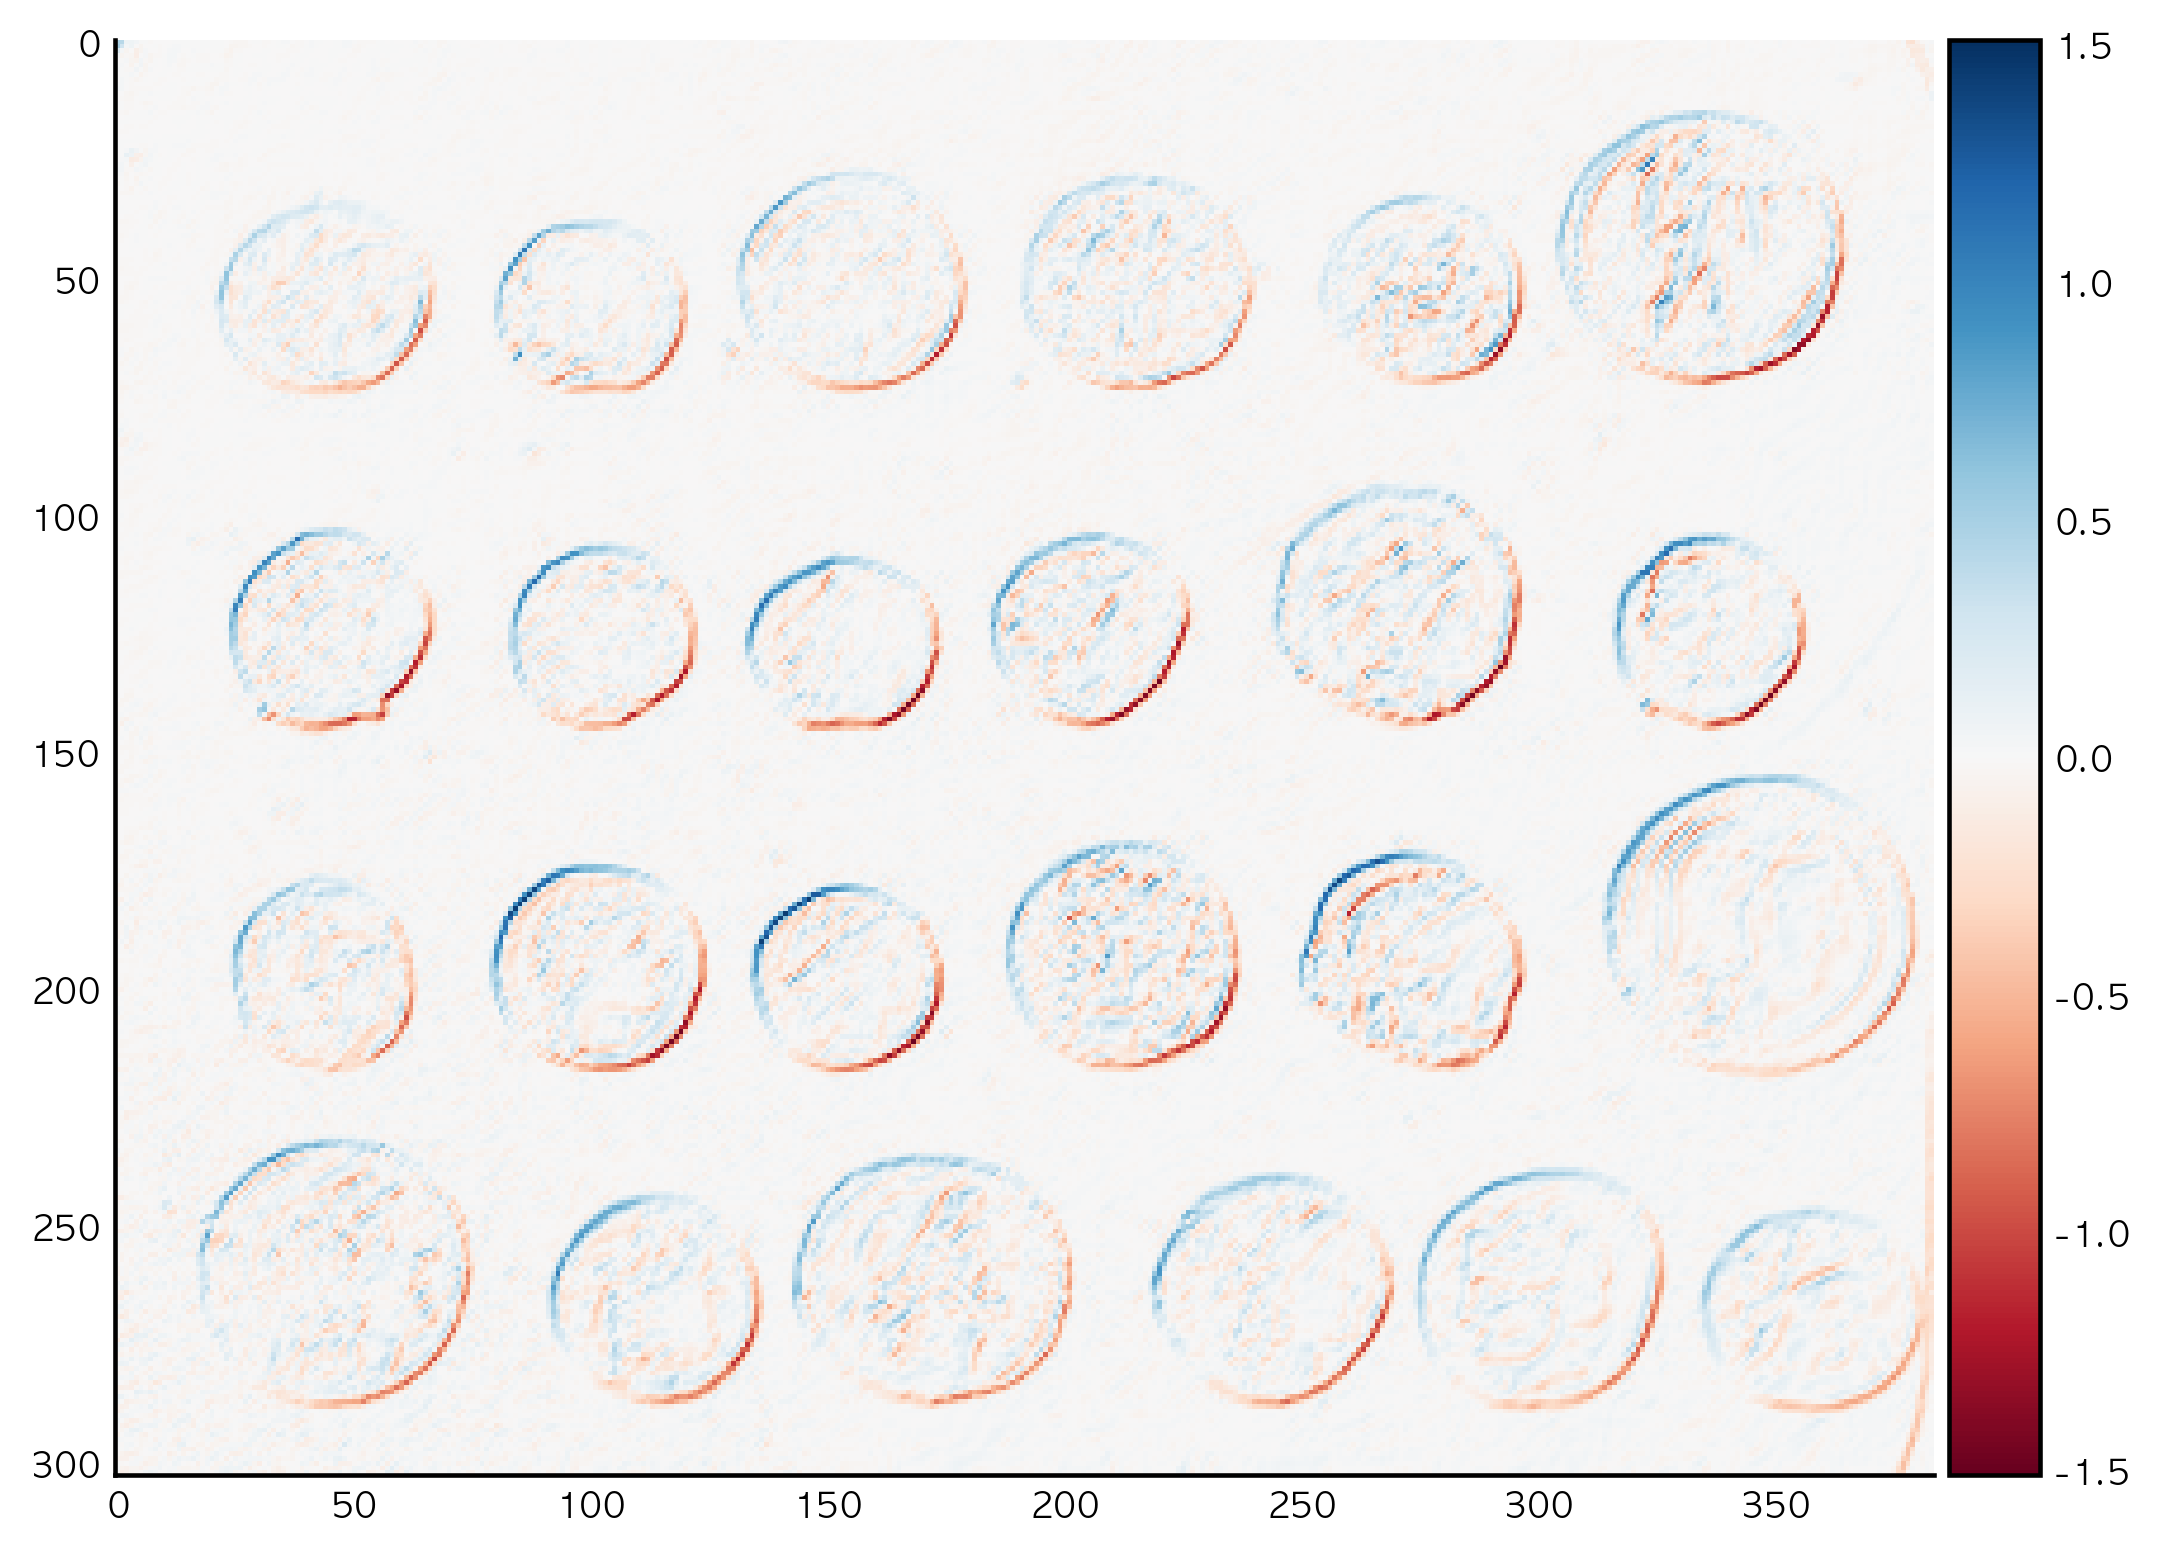

In [20]:
coins = coins.astype(float) / 255
diff2d = np.array([[0, 1, 0], [1, 0, -1], [0, -1, 0]])
coins_edges = ndi.convolve(coins, diff2d)
io.imshow(coins_edges);

In [21]:
# raw vector to find horizontal edge
hdiff = np.array([[1], [0], [-1]])

In [22]:
hsobel = np.array([ [1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])

In [23]:
vsobel = hsobel.T

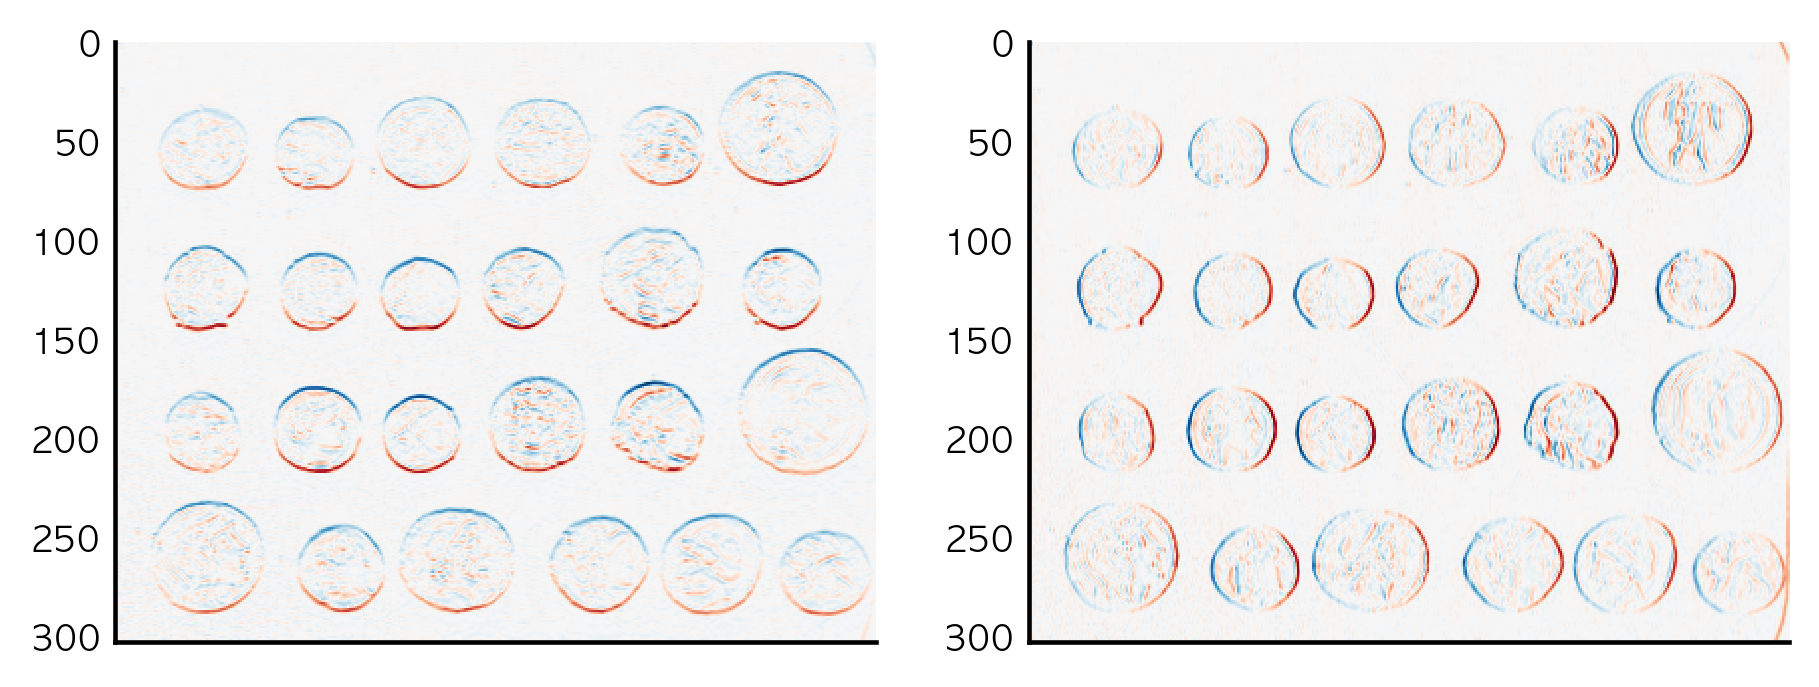

In [25]:
# For readability, customized x axis label
def reduce_xaxis_labels(ax, factor):
    """only shows ith labels to prevent crowed on x axis
       ex) factor = 2 draws x axis labels for each second
       
    parameter
    -----------------
    ax : matplotlib axis
    factor : integer, element to reduce the number of x label
    """
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(True)
    
coins_h = ndi.convolve(coins, hsobel)
coins_v = ndi.convolve(coins, vsobel)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h, cmap=plt.cm.RdBu)
axes[1].imshow(coins_v, cmap=plt.cm.RdBu)
for ax in axes:
    reduce_xaxis_labels(ax, 2)

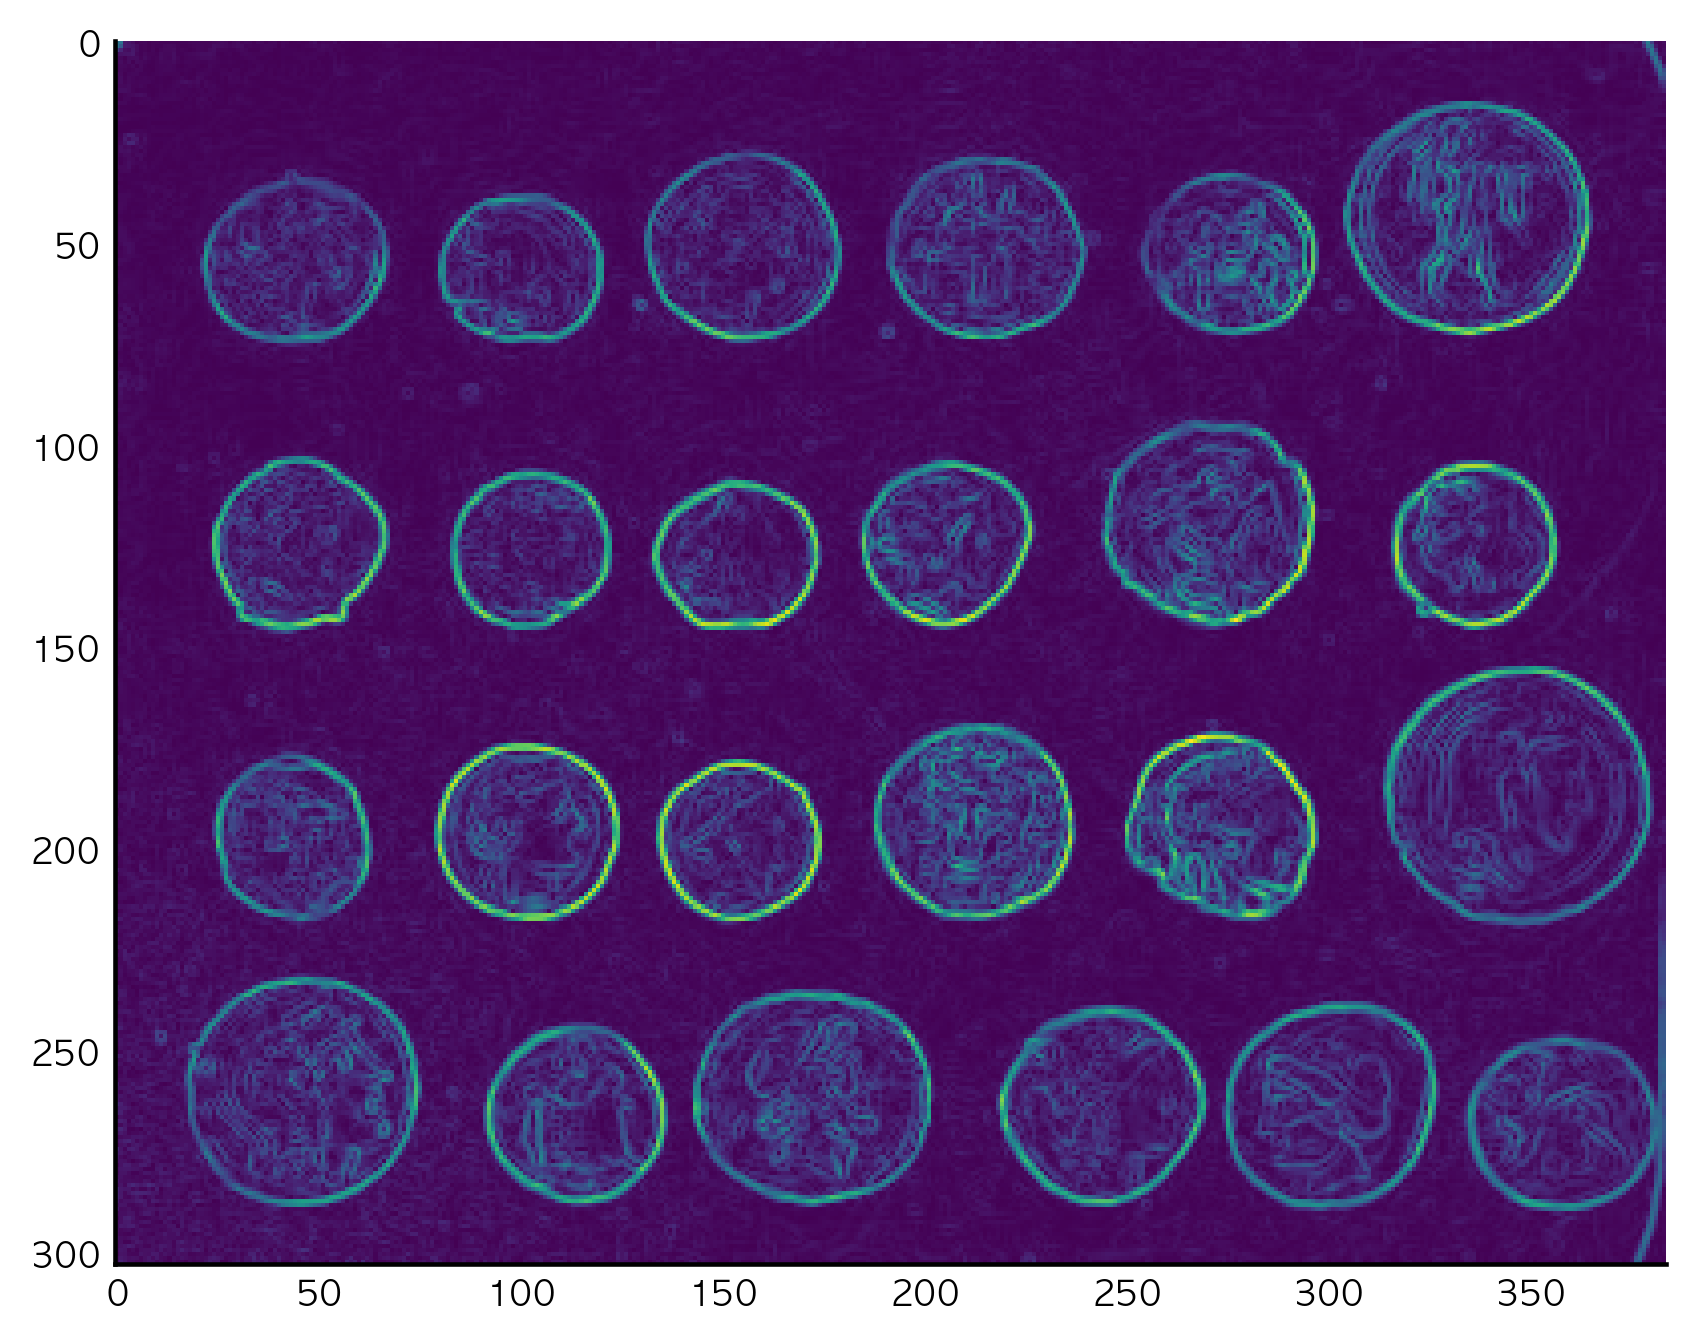

In [26]:
coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

## 3.4 Generic Filter: Arbitrary Function of Near-value

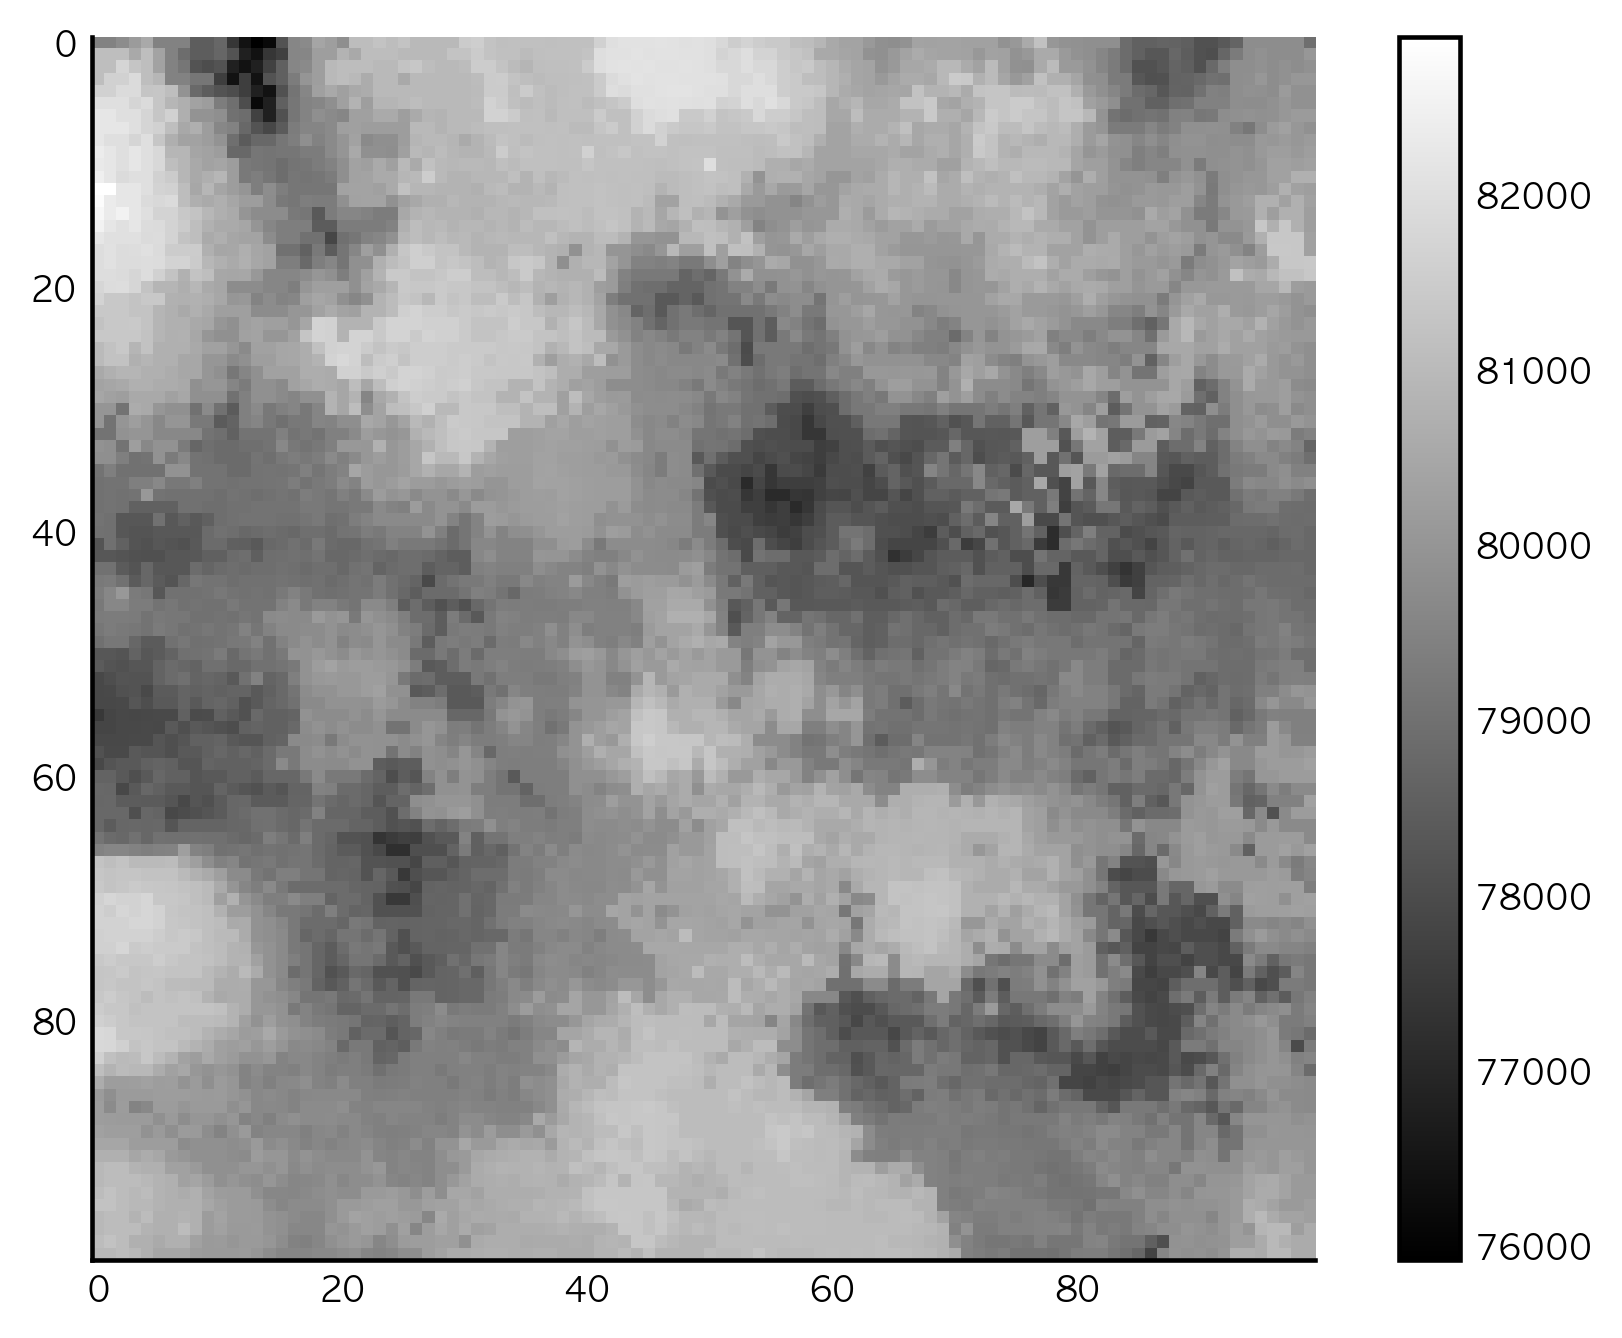

In [27]:
from skimage import morphology

def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)

house_price_map = (0.5 + np.random.rand(100, 100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(house_price_map, tax, footprint=footprint)
plt.imshow(tax_rate_map)
plt.colorbar();